# Bibliotecas

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import unidecode
from wordcloud import WordCloud

import gensim.corpora as corpora
from gensim.models import KeyedVectors

import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

from IPython.display import clear_output

nltk.download('stopwords')
nltk.download('punkt')

plt.style.use('seaborn')
sns.set(style="whitegrid")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joaorobson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/joaorobson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Introdução

O objetivo desse notebook é realizar uma análise de dados relativos a licitações realizadas no estado do Rio Grande do Sul entre 2016 e 2019. 

O notebook está divido em 3 grandes seções de análise:
* Análise dos gastos das licitações, incluindo a comparação entre valores estimados e homologados;
* Análise da relação entre o tamanho dos municípios e os valores totais gastos por cada um;
* Análise dos itens comprados nas licitações.

O dicionário de dados com informações adicionais se encontra nesse [link](http://www1.tce.rs.gov.br/portal/page/portal/tcers/jurisdicionados/sistemas_controle_externo/licitacon/e-validador/manual/eValidador_LicitaCon_Manual_Leiaute_1.4.pdf).


# Leitura dos dados

Para facilitar a manipulação dos dados, os dados de 2016 a 2019 serão lidos e integrados a um único dataframe.

In [2]:
years = [str(year) for year in range(2016, 2020)]

bids = pd.DataFrame()
items = pd.DataFrame()

for year in years:
    new_bids = pd.read_csv(f'{year}.csv/licitacao.csv')
    new_items = pd.read_csv(f'{year}.csv/licitacao.csv')
    
    bids = pd.concat([bids, new_bids])
    items = pd.concat([items, new_items])

/home/joaorobson/Documentos/DSB/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (52,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/joaorobson/Documentos/DSB/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (52,53,54,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/joaorobson/Documentos/DSB/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (53,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Como recomendado no enuncidado do teste, vamos utilizar apenas
# licitações cujo tipo de objeto é "compras"
bids = bids[bids["TP_OBJETO"] == "COM"].reset_index(drop=True)
items = items[items["TP_OBJETO"] == "COM"].reset_index(drop=True)

É importante também, para auxiliar nas análises, manter apenas colunas de interesse. As colunas mantidas para o dataset de licitações serão:
* CD_ORGAO;
* NM_ORGAO;
* NR_LICITACAO;
* ANO_LICITACAO;
* CD_TIPO_MODALIDADE;
* VL_LICITACAO (valor estimado para a licitação);
* VL_HOMOLOGADO (valor homologado para a licitação);
* NR_PROCESSO.

Já para o dataset dos itens:

* CD_ORGAO;
* NR_LICITACAO;
* ANO_LICITACAO;
* DS_OBJETO;
* CD_TIPO_MODALIDADE;
* NR_PROCESSO.

In [4]:
# Manter apenas colunas de interesse
bids = bids[["CD_ORGAO", "NM_ORGAO", "NR_LICITACAO", "ANO_LICITACAO", "CD_TIPO_MODALIDADE",
            "VL_LICITACAO", "VL_HOMOLOGADO", "NR_PROCESSO"]]
items = items[["CD_ORGAO", "NR_LICITACAO","ANO_LICITACAO", "DS_OBJETO", "CD_TIPO_MODALIDADE", "NR_PROCESSO"]]

In [5]:
# Tipos das colunas do dado de licitações
bids.dtypes

CD_ORGAO                int64
NM_ORGAO               object
NR_LICITACAO          float64
ANO_LICITACAO           int64
CD_TIPO_MODALIDADE     object
VL_LICITACAO          float64
VL_HOMOLOGADO          object
NR_PROCESSO            object
dtype: object

In [6]:
# Tipos das colunas do dado de itens
items.dtypes

CD_ORGAO                int64
NR_LICITACAO          float64
ANO_LICITACAO           int64
DS_OBJETO              object
CD_TIPO_MODALIDADE     object
NR_PROCESSO            object
dtype: object

É importante transformar o tipo da coluna *VL_HOMOLOGADO* para float, como a coluna *VL_LICITACAO*:

In [7]:
# items["VL_HOMOLOGADO"] = pd.to_numeric(items["VL_HOMOLOGADO"], errors='coerce')
bids["VL_HOMOLOGADO"] = pd.to_numeric(bids["VL_HOMOLOGADO"], errors='coerce')

In [8]:
bids.head()

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,VL_LICITACAO,VL_HOMOLOGADO,NR_PROCESSO
0,84100,PM DE ESPERANÇA DO SUL,4.0,2016,CNV,11216.5,NaN,003
1,82701,CM DE XANGRI-LÁ,1.0,2016,PRP,NaN,NaN,01
2,84100,PM DE ESPERANÇA DO SUL,6.0,2016,CNV,59810.6,NaN,005
3,53100,PM DE NOVA PALMA,3.0,2016,PRP,251.7,NaN,07
4,86800,PM DE BOA VISTA DO SUL,3.0,2016,PRP,31384.9,NaN,004


In [9]:
items.head()

,CD_ORGAO,NR_LICITACAO,ANO_LICITACAO,DS_OBJETO,CD_TIPO_MODALIDADE,NR_PROCESSO
0,84100,4.0,2016,Aquisição de merenda escolar,CNV,003
1,82701,1.0,2016,AQUISIÇÃO DE PROTOCOLADORA E FRAGMENTADORA DE ...,PRP,01
2,84100,6.0,2016,Aquisição de materiais de limpeza para as dive...,CNV,005
3,53100,3.0,2016,Aquisição de tubos de concreto,PRP,07
4,86800,3.0,2016,Aquisição de tubos de concreto,PRP,004


# Análise inicial do dado

## Dados sobre valores e quantidades de licitações

In [10]:
print('Número de licitações de compras feitas entre 2016 e 2019:', len(bids))

Número de licitações de compras feitas entre 2016 e 2019: 82405


In [11]:
print("Número de licitações de compras sem valor homologado:", 
      bids["VL_HOMOLOGADO"].isna().sum())
print("Número de licitações de compras com valor homologado igual a zero:", 
      len(bids[bids["VL_HOMOLOGADO"] == 0]))

Número de licitações de compras sem valor homologado: 48216
Número de licitações de compras com valor homologado igual a zero: 10415


In [12]:
print("Número de licitações de compras sem valor estimado:", 
      bids["VL_LICITACAO"].isna().sum() )
print("Número de licitações de compras com valor estimado igual a zero:", 
      len(bids[bids["VL_LICITACAO"] == 0]))

Número de licitações de compras sem valor estimado: 6046
Número de licitações de compras com valor estimado igual a zero: 4460


De 82.405 licitações, mais da metade (58.631) se encontra sem o valor homologado e um pouco mais de 10.000 (10.506) não tem valor estimado. Por enquanto, esses registros não serão removidos nem substituídos, por dois motivos:
* Os municípios de origem dessas licitações serão analisados e a distribuição desses registros sem valor entre eles será analisada;
* Em uma etapa posterior, na análise dos itens adquiridos nas licitações, um padrão de compra pode ser identificado e os valores faltantes estimados.

Além disso, nas análises feitas abaixo no dado de licitações, registros que possuem *NaN* em um campo numérico, como o caso de *VL_LICITACAO*, são desconsiderados nas operações de média, contagem, etc. e em diversas ocasiões não impactam nos resultados mostrados.

## Dados sobre órgãos

In [13]:
print('Número de órgaos distintos:', len(bids["CD_ORGAO"].unique()))

Número de órgaos distintos: 843


# Análise dos gastos com as licitações de compras

## Evolução dos gastos ao longo dos anos

Um ponto importante a se entender é como o gasto anual com licitações mudou ao longo do tempo. Por meio dessa análise, é possível ver se há uma variação considerável entre os anos e se sim, tentar entender o porquê.

In [14]:
# Agrupar os gastos com licitações por ano, calcular a média por ano e gerar um novo dataframe
annual_spending = bids.groupby("ANO_LICITACAO")["VL_HOMOLOGADO"].sum().reset_index()

In [15]:
annual_spending

,ANO_LICITACAO,VL_HOMOLOGADO
0,2016,5.673030e+09
1,2017,1.939957e+09
2,2018,1.745977e+09
3,2019,3.219983e+09


In [16]:
# Agrupar o número de licitações por ano usando o método count e gerar um novo dataframe
num_bids = bids.groupby("ANO_LICITACAO")["VL_HOMOLOGADO"].count().reset_index()
num_bids.rename(columns={"VL_HOMOLOGADO":"NUM_LICITACOES"}, inplace=True)

In [17]:
num_bids

,ANO_LICITACAO,NUM_LICITACOES
0,2016,5645
1,2017,9687
2,2018,9823
3,2019,9034


In [18]:
num_bids_no_value = bids[bids["VL_HOMOLOGADO"].isna()].groupby("ANO_LICITACAO")["CD_ORGAO"].count().reset_index()
num_bids_no_value.rename(columns={"CD_ORGAO":"NUM_LICITACOES"}, inplace=True)

In [19]:
num_bids_no_value

,ANO_LICITACAO,NUM_LICITACOES
0,2016,6904
1,2017,12938
2,2018,15078
3,2019,13296


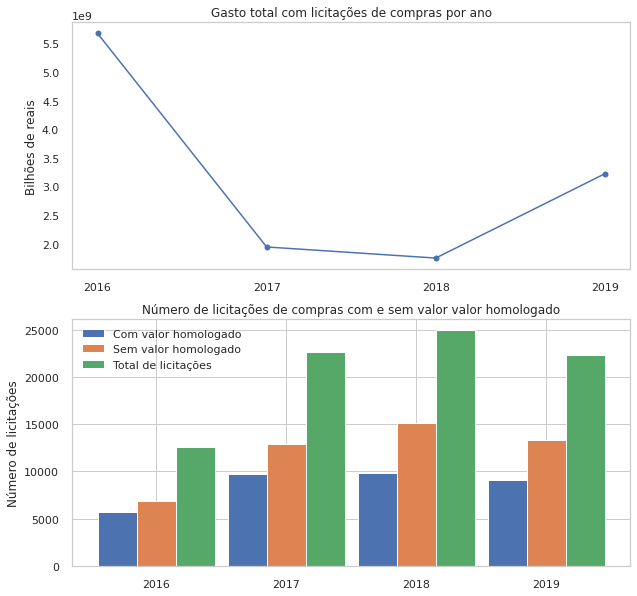

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

ax1.plot(annual_spending["ANO_LICITACAO"], annual_spending["VL_HOMOLOGADO"], '-o')

ax1.set_title("Gasto total com licitações de compras por ano")
ax1.set_xticks(annual_spending["ANO_LICITACAO"])
ax1.set_ylabel("Bilhões de reais")
ax1.grid()


labels = num_bids["ANO_LICITACAO"]
num_bids_with_value = num_bids["NUM_LICITACOES"]
num_bids_without_value = num_bids_no_value["NUM_LICITACOES"]
total_bids = num_bids["NUM_LICITACOES"] + num_bids_no_value["NUM_LICITACOES"]

x = np.arange(len(labels))
width = 0.3

rects1 = ax2.bar(x, num_bids_with_value, width, label='Com valor homologado')
rects2 = ax2.bar(x + width, num_bids_without_value, width, label='Sem valor homologado')
rects2 = ax2.bar(x + 2*width, total_bids, width, label='Total de licitações')


ax2.set_ylabel('Número de licitações')
ax2.set_title('Número de licitações de compras com e sem valor valor homologado')
ax2.set_xticks(x + width)
ax2.set_xticklabels(labels)
ax2.legend()


plt.show()



Realizando uma análise nos dados mostrado acima, pode-se observar que houve uma diminuição considerável de gastos com licitações entre os anos de 2016 e 2017 (de quase 3 vezes) e de 2018 para 2019 outro aumento, de cerca de 50%.

O primeiro fato ocorreu apesar do total de licitações ter praticamente dobrado entre esses dois anos e do maior número de licitações com valor homologado em 2017. O segundo mesmo com o número de licitações mantido praticamente no mesmo nível.

O que será que causou esses aumentos? A resposta pode ser encontrada nos itens que compõem as licitações de cada ano e nos órgãos que realizaram essas licitações.

Porém, antes de analisar os itens e os órgãos, vamos analisar a relação entre os gastos e os municípios de origem das licitações.

## Relação entre valores estimados e valores homologados das licitações

Outra análise importante a ser feita é a comparação entre os valores previstos para as licitações e os valores confirmados pelo governo ao fim do processo licitatório. Para isso, um gráfico com a distribuição das razões entre o valor homologado e estimado para os registros que possuem valores válidos (que não são nem *NaN* nem 0) será plotado. Por meio desse gráfico, é possível saber se há uma presença grande de licitações cujo o valor estimado foi bem abaixo do homologado.

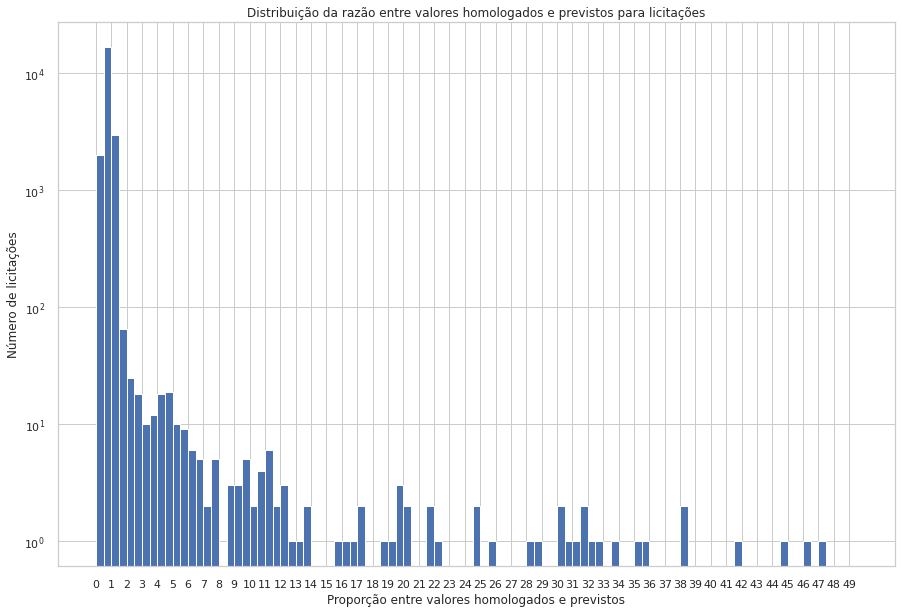

In [185]:
estimated_vs_homol = bids[(~bids["VL_LICITACAO"].isna()) 
                          & (~bids["VL_HOMOLOGADO"].isna())
                          & (bids["VL_LICITACAO"] != 0)
                          & (bids["VL_HOMOLOGADO"] != 0)]

estim_homol_ratio = estimated_vs_homol["VL_HOMOLOGADO"]/estimated_vs_homol["VL_LICITACAO"]

plt.figure(figsize=(15,10))
plt.title("Distribuição da razão entre valores homologados e previstos para licitações")
plt.hist(estim_homol_ratio, bins=np.arange(0, 50, 0.5))
plt.xticks(list(range(0,50,1)))
plt.ylabel("Número de licitações")
plt.xlabel("Proporção entre valores homologados e previstos")
plt.yscale('log')
plt.show()

Vemos pelo gráfico acima que uma parte significativa das licitações foi homologada com valor igual ou menor do que o previsto. Entretanto, há uma quantitade razoável das licitações que possui um valor superior ao previsto. Vamos ver quantas licitações do total passaram do valor estimado:

In [22]:
greater_than_estimated = estim_homol_ratio[estim_homol_ratio > 1].count()
less_than_estimated = estim_homol_ratio[estim_homol_ratio <= 1].count()

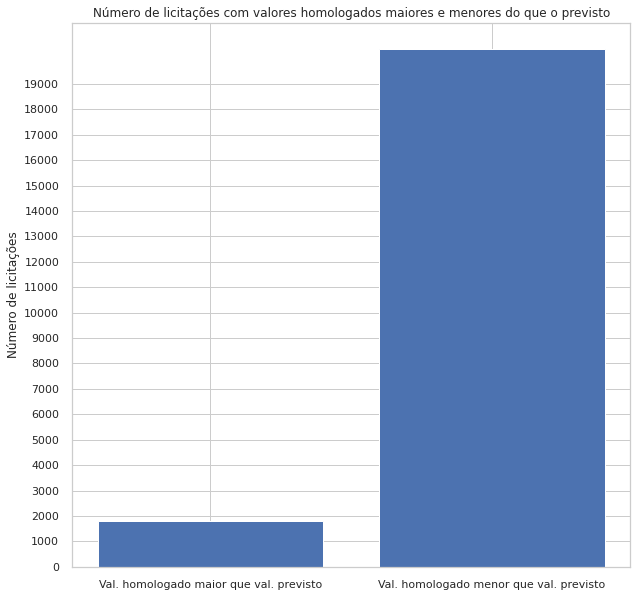

In [23]:
plt.figure(figsize=(10,10))
plt.title("Número de licitações com valores homologados maiores e menores do que o previsto")
plt.bar(["Val. homologado maior que val. previsto",  "Val. homologado menor que val. previsto"],
        [greater_than_estimated, less_than_estimated])
plt.ylabel("Número de licitações")
plt.yticks(list(range(0, 20000, 1000)))
plt.show()

Vemos que a maior parte esmagadora das licitações que possuem valores homologados definidos não ultrapassaram o valor previsto. Vamos plotar o mesmo gráfico, mas considerando os valores monetários:

In [24]:
greater_than_estimated_spendings = 0
less_than_estimated_spendings = 0
for estimated, homol in estimated_vs_homol[["VL_LICITACAO", "VL_HOMOLOGADO"]].values:
    if homol <= estimated:
        less_than_estimated_spendings += homol
    else:
        greater_than_estimated_spendings += homol

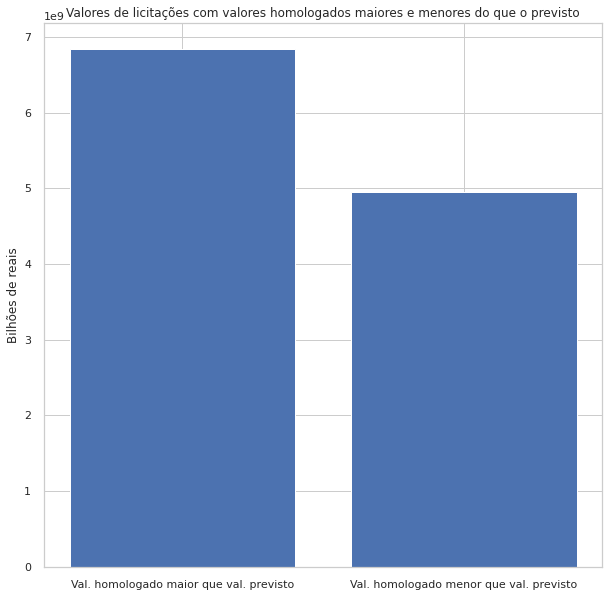

In [25]:
plt.figure(figsize=(10,10))
plt.title("Valores de licitações com valores homologados maiores e menores do que o previsto")
plt.bar(["Val. homologado maior que val. previsto",  "Val. homologado menor que val. previsto"],
        [greater_than_estimated_spendings, less_than_estimated_spendings])
plt.ylabel("Bilhões de reais")
plt.show()

O resultado acima é de certa forma surpreendente: apesar de menos de 10% das licitações serem homologadas com valores maiores que o previsto, o valor total dessas licitações ultrapassa em mais de um bilhão de reais o valor total das licitações que seguem o valor previsto ou até são mais baratas quando homologadas.

Várias hipóteses podem justificar esse resultado:
* Para compras de grande valor, o processo de decisão dos valores tende a subestimar os valores e por isso há um grau de variabilidade grande;
* Demora entre a estimativa do preço das compras licitadas e a homologação em si, o que gera mudança brusca dos valores;
* Pouca concorrência na licitação. Com menos oferta, os valores pedidos pelos fornecedores cresce;
* Entre outros.

Infelizmente, os pontos citados possuem um grau de complexidade maior para serem analisados, o que foge do objetivo dessa análise.

# Análise da relação entre o tamanho dos municípios e seus gastos



## Captura do nome dos municípios
No dado original, não existe uma coluna específica indicando o município do órgão citado. Apesar disso, nos dados textuais da coluna "NM_ORGAO" é possível encontrar o nome dos municípios. 

Dessa maneira, é possível utilizar o dado disponibilizado no site do [IBGE](https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html?=&t=resultados), que contém o nome de todos os municípios brasileiros e as estimativas para a população dos mesmos em 2020, e (tentar) extrair os municípios a partir do nome dos órgãos.

In [26]:
cities = pd.read_excel("POP2020_20210204.xls")

In [27]:
cities

,UF,COD. UF,COD. MUNIC,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA
0,RO,11,15,Alta Floresta D'Oeste,22728
1,RO,11,23,Ariquemes,109523
2,RO,11,31,Cabixi,5188
3,RO,11,49,Cacoal,85893
4,RO,11,56,Cerejeiras,16204
...,...,...,...,...,...
5565,GO,52,22005,Vianópolis,13977
5566,GO,52,22054,Vicentinópolis,8873
5567,GO,52,22203,Vila Boa,6312
5568,GO,52,22302,Vila Propício,5882


In [28]:
cities.dtypes

UF                    object
COD. UF                int64
COD. MUNIC             int64
NOME DO MUNICÍPIO     object
POPULAÇÃO ESTIMADA    object
dtype: object

Primeiramente, vamos processar o dado. Há quatro passos a serem feitos:
* Excluir as colunas de metadados "COD. UF" e "COD. MUNIC", porque não são importantes para a análise feita aqui;
* Filtrar o dado original, mantendo apenas os dados referentes aos municípos do Rio Grande do Sul;
* Colocar o nome dos municípios em caixa alta, pois o nome dos órgãos está formatado assim;
* Transformar a coluna com os valores das populações para inteiro.

In [29]:
cities.drop(columns=["COD. UF", "COD. MUNIC"], inplace=True)

In [30]:
cities_rs = cities[cities["UF"] == "RS"].reset_index(drop=True)
cities_rs.head()

,UF,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA
0,RS,Aceguá,4942
1,RS,Água Santa,3743
2,RS,Agudo,16401
3,RS,Ajuricaba,6987
4,RS,Alecrim,5827


In [31]:
cities_rs["NOME DO MUNICÍPIO"] = cities_rs["NOME DO MUNICÍPIO"].apply(lambda name: name.upper())

In [32]:
cities_rs.head()

,UF,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA
0,RS,ACEGUÁ,4942
1,RS,ÁGUA SANTA,3743
2,RS,AGUDO,16401
3,RS,AJURICABA,6987
4,RS,ALECRIM,5827


In [33]:
cities_rs["NOME DO MUNICÍPIO"].values

array(['ACEGUÁ', 'ÁGUA SANTA', 'AGUDO', 'AJURICABA', 'ALECRIM',
       'ALEGRETE', 'ALEGRIA', 'ALMIRANTE TAMANDARÉ DO SUL', 'ALPESTRE',
       'ALTO ALEGRE', 'ALTO FELIZ', 'ALVORADA', 'AMARAL FERRADOR',
       'AMETISTA DO SUL', 'ANDRÉ DA ROCHA', 'ANTA GORDA', 'ANTÔNIO PRADO',
       'ARAMBARÉ', 'ARARICÁ', 'ARATIBA', 'ARROIO DO MEIO',
       'ARROIO DO SAL', 'ARROIO DO PADRE', 'ARROIO DOS RATOS',
       'ARROIO DO TIGRE', 'ARROIO GRANDE', 'ARVOREZINHA',
       'AUGUSTO PESTANA', 'ÁUREA', 'BAGÉ', 'BALNEÁRIO PINHAL', 'BARÃO',
       'BARÃO DE COTEGIPE', 'BARÃO DO TRIUNFO', 'BARRACÃO',
       'BARRA DO GUARITA', 'BARRA DO QUARAÍ', 'BARRA DO RIBEIRO',
       'BARRA DO RIO AZUL', 'BARRA FUNDA', 'BARROS CASSAL',
       'BENJAMIN CONSTANT DO SUL', 'BENTO GONÇALVES',
       'BOA VISTA DAS MISSÕES', 'BOA VISTA DO BURICÁ',
       'BOA VISTA DO CADEADO', 'BOA VISTA DO INCRA', 'BOA VISTA DO SUL',
       'BOM JESUS', 'BOM PRINCÍPIO', 'BOM PROGRESSO', 'BOM RETIRO DO SUL',
       'BOQUEIRÃO DO LEÃO',

In [34]:
cities_rs["POPULAÇÃO ESTIMADA"] = cities_rs["POPULAÇÃO ESTIMADA"].astype(int)

Agora, para realizar a extração, podemos começar com um algoritmo simples que, para cada órgão, percorre a lista de todos os municípios e checa se há algum deles em seu nome.

In [35]:
matches = {}
not_found_cities = []

#Percorre todos os órgãos
for agency in bids["NM_ORGAO"].unique():
    # Percorre todos os municípios
    for city in cities_rs["NOME DO MUNICÍPIO"]:
        # Se encontrou um nome de município no nome do órgão,
        # para o loop
        if city in agency:
            matches.update({agency: city})
            break
    # Se não houve nenhum match, adiciona órgão a lista
    # de órgão com município não identificado
    else:
        not_found_cities.append(agency)

In [36]:
print("Órgãos com municípios não encontrados:", len(not_found_cities))
print("Órgãos com municípios encontrados:", len(matches))

Órgãos com municípios não encontrados: 72
Órgãos com municípios encontrados: 771


De 843 órgãos, o algoritmo não encontrou o municípo de 72, cerca de 8%. Vamos ver se ainda é possível identificar os municípios nesses casos:

In [37]:
not_found_cities

['SERVIÇO AUTÔN. MUN. DE ÁGUA E ESGOTO - CX.SUL',
 'CIA. CARRIS PORTO-ALEGRENSE',
 'INST. DE PREV. E ASSIST. DOS SERV. MUNIC. DE N. HAMBURGO',
 'EMPRESA PÚBLICA DE TRANSPORTE E CIRCULAÇÃO S/A.',
 'CONS. INTERM. DO VALE DO JACUÍ - CI/JACUÍ',
 'CONS. PÚBL. INTERM. P/ ASSUNTOS ESTRATÉGICOS DO G8 - CIPAE G8',
 'CONS. INTERM. - CI - CENTRO SUL',
 'CONS. PÚBL. DO EXTREMO SUL',
 'CONS. INTERM. SAÚDE DO NOROESTE DO ESTADO DO RS',
 'CONS. INTERM. DE DESENV. SUSTENT. DA SERRA GAÚCHA - CISGA',
 'INST. PREV.  ASSIST. À SAÚDE SERV. PÚBL. MUN. DE S. MARIA',
 'INSTITUTO ERECHINENSE DE PREVIDÊNCIA - IEP',
 'SISTEMA DE PREVIDÊNCIA MUNICIPAL - S. LIVRAMENTO',
 'CONS. DE DESENV. INTERM. DOS MUNIC. DO ALTO JACUÍ',
 'CONS. PÚBL. SAN. BÁSICO DA BACIA HIDROG. DO RIO DOS SINOS',
 'CONS. INTERM. LAR DE ACOLHIMENTO SÃO FRANCISCO',
 'FENAC S.A. FEIRAS E EMPREEND. TURÍSTICOS - N. HAMBURGO',
 'CONS. INTERM. DE SAÚDE - CONISA',
 'CONS. INTERM. DA REGIÃO CENTRO DO ESTADO DO RS - CI/CENTRO STA. MARIA',
 'CONS. INTERM

Vemos que em boa parte desses casos, não há a presença do nome do município. Porém, em alguns, o nome do município está abreviado ("N. HAMBURGO", "STA. MARIA", "CX. SUL", "P. FUNDO", "S. LEOPOLDO", "S. LIVRAMENTO", "S. GABRIEL", etc.), em outros com acentuação diferente ("RESTINGA SECA", "GRAVATAI") e um caso onde havia um espaço duplicado ("CAPÃO DA  CANOA").

Para esses poucos casos, vamos fazer a atribuição manualmente:

In [38]:
matches.update({'SERVIÇO AUTÔN. MUN. DE ÁGUA E ESGOTO - CX.SUL': 'CAXIAS DO SUL', 
                'CM DE RESTINGA SECA': 'RESTINGA SÊCA', 
                'INST. DE PREV. E ASSIST. DOS SERV. MUNIC. DE N. HAMBURGO': 'NOVO HAMBURGO', 
                'INST. PREV.  ASSIST. À SAÚDE SERV. PÚBL. MUN. DE S. MARIA': 'SANTA MARIA',
                'HOSP. BENEF. DR. CÉSAR SANTOS - P. FUNDO': 'PASSO FUNDO', 
                'FENAC S.A. FEIRAS E EMPREEND. TURÍSTICOS - N. HAMBURGO': 'NOVO HAMBURGO', 
                'INSTITUTO DE PREVIDENCIA DOS SERVIDORES MUNICIPAIS DE GRAVATAI': 'GRAVATAÍ', 
                'SISTEMA DE PREVIDÊNCIA MUNICIPAL - S. LIVRAMENTO': "SANT'ANA DO LIVRAMENTO", 
                'PM DE RESTINGA SECA': 'RESTINGA SÊCA', 
                'INST. MUN. SEGURIDADE SOCIAL - CAPÃO DA  CANOA': 'CAPÃO DA CANOA', 
                'SERVIÇO MUN. DE ÁGUA E ESGOTOS - S. LEOPOLDO': 'SÃO LEOPOLDO', 
                'INST. MUN. PREV. ASSIST. SERV. S. BÁRBARA DO SUL - IMPAS': 'SANTA BÁRBARA DO SUL', 
                'AGASA - CIA. DE DESENV. ECON. E SOCIAL - S. A. PATRULHA': 'SANTO ANTÔNIO DA PATRULHA',
                'CAIXA PREST. ASSIST. SERV. SAÚDE DOS SERV. MUN. DE P. FUNDO': 'PASSO FUNDO',
                'AGÊNCIA MUN. REGULAÇÃO  DOS SERV. PÚBL. DELEG. DE S. GABRIEL': 'SÃO GABRIEL'})

In [39]:
not_found_cities = [agency for agency in not_found_cities if agency not in [match for match in matches.keys()]]

In [40]:
print("Órgãos com municípios não encontrados:", len(not_found_cities))
print("Órgãos com municípios encontrados:", len(matches))

Órgãos com municípios não encontrados: 63
Órgãos com municípios encontrados: 786


Vamos adicionar a coluna que identifica o município para cada linha de nosso dataframe:

In [41]:
cities_column = []

for agency in bids["NM_ORGAO"]:
    if agency in matches:
        cities_column.append(matches[agency])
    else:
        cities_column.append(None)
        

In [42]:
bids["NOME DO MUNICÍPIO"] = cities_column

In [43]:
print("Número de municípios distintos encontrados:", len(bids["NOME DO MUNICÍPIO"].unique()))
print("Total de municípios no RS:", len(cities_rs))

Número de municípios distintos encontrados: 468
Total de municípios no RS: 497


## Gastos dos órgãos com municípios encontrados  vs órgãos com municípios não encontrados

Primeiramente, é importante analisar se o gasto dos órgãos que não puderam ter seu município extraído pela etapa anterior é considerável em relação ao gasto total

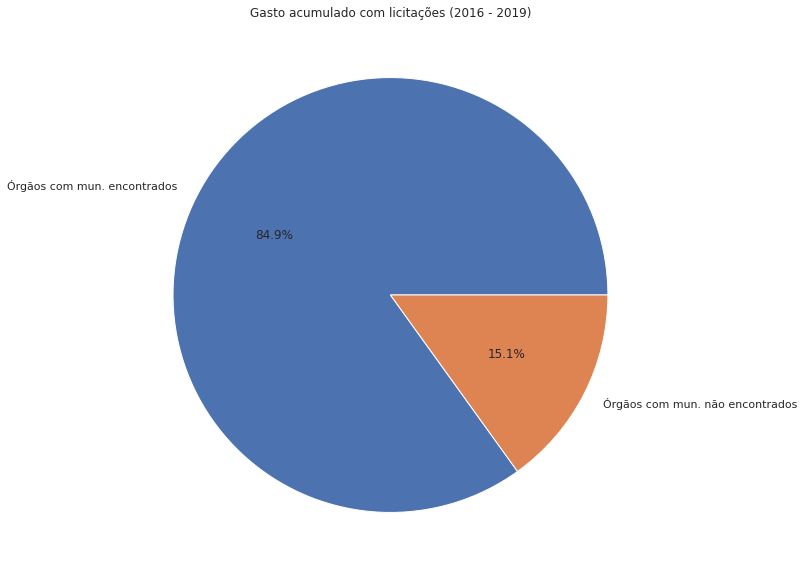

In [44]:
plt.figure(figsize=(10,10))
plt.pie([bids[~bids["NOME DO MUNICÍPIO"].isna()]["VL_LICITACAO"].sum(),
         bids[bids["NOME DO MUNICÍPIO"].isna()]["VL_LICITACAO"].sum()], 
        labels=["Órgãos com mun. encontrados", "Órgãos com mun. não encontrados"],
        autopct='%1.1f%%')
plt.title("Gasto acumulado com licitações (2016 - 2019)")
plt.show()

Observando o gráfico acima, vemos que o gasto dos órgãos que não tiveram os municípios encontrados é importante (15.1%), porém consideravelmente menor do que para os órgãos cujo os municípios se conhece. 

Como o objetivo é determinar um padrão de gasto de acordo com o tamanho dos municípios, essa fatia não será grande problema, tendo em vista que há 468 municípios identificados no dado de licitações, dos 497 existentes no RS.

Sendo assim, vamos prosseguir com a análise da relação entre a população dos municípios e seus gastos

In [45]:
bids[bids["VL_HOMOLOGADO"].isna()].groupby("NOME DO MUNICÍPIO").count().sort_values("CD_ORGAO")

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,VL_LICITACAO,VL_HOMOLOGADO,NR_PROCESSO
NOME DO MUNICÍPIO,,,,,,,,
SANTANA DA BOA VISTA,1,1,1,1,1,1,0,1
BOSSOROCA,1,1,1,1,1,1,0,1
TAVARES,1,1,1,1,1,1,0,1
BOM PROGRESSO,1,1,1,1,1,1,0,1
LIBERATO SALZANO,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...
PORTO ALEGRE,516,516,516,516,516,299,0,516
CAXIAS DO SUL,848,848,848,848,848,605,0,848
ERECHIM,963,963,963,963,963,962,0,963


## Relação entre população do município e gasto com licitações

Agora, podemos analisar se há alguma relação entre o número de habitantes de um municípo, que é uma variável teoricamente relacionada com seu tamanho, e o seu gasto com licitações.

In [46]:
spending_per_city = bids.groupby("NOME DO MUNICÍPIO").mean().reset_index()[["NOME DO MUNICÍPIO", "VL_HOMOLOGADO"]]
spending_per_city

,NOME DO MUNICÍPIO,VL_HOMOLOGADO
0,ACEGUÁ,81916.317000
1,AGUDO,109878.710756
2,AJURICABA,50000.965482
3,ALECRIM,41999.395903
4,ALEGRETE,150371.823778
...,...,...
462,VITÓRIA DAS MISSÕES,103254.854943
463,WESTFÁLIA,29584.933333
464,XANGRI-LÁ,524064.993333
465,ÁGUA SANTA,NaN


In [47]:
spending_per_city = pd.merge(spending_per_city, cities_rs[["NOME DO MUNICÍPIO", "POPULAÇÃO ESTIMADA"]], on="NOME DO MUNICÍPIO")


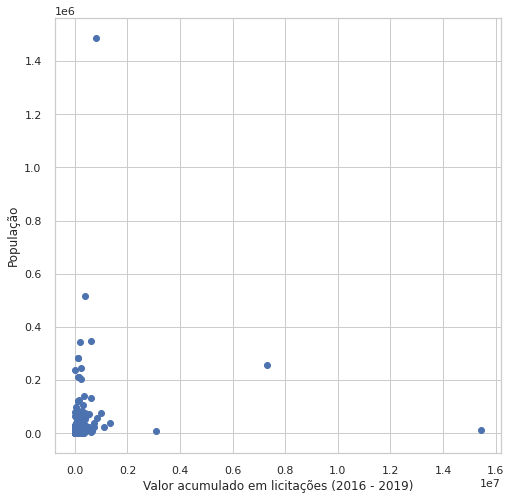

In [48]:
plt.figure(figsize=(8,8))
plt.scatter(spending_per_city["VL_HOMOLOGADO"],spending_per_city["POPULAÇÃO ESTIMADA"])
plt.ylabel("População")
plt.xlabel("Valor acumulado em licitações (2016 - 2019)")
plt.show()

O gráfico acima não ficou com um resultado visual muito bom. Isso se deve à diferença na amplitude dos valores plotados, que é muito grande, como podemos ver abaixo:

In [49]:
spending_per_city.describe()

,VL_HOMOLOGADO,POPULAÇÃO ESTIMADA
count,3.890000e+02,4.670000e+02
mean,1.974563e+05,2.419512e+04
std,8.822007e+05,8.345207e+04
min,0.000000e+00,9.820000e+02
25%,5.003860e+04,3.010500e+03
50%,8.467727e+04,5.827000e+03
75%,1.526496e+05,1.667900e+04
max,1.543383e+07,1.488252e+06


Temos um desvio padrão de 80.000 para a população e de 800.000 para os valores de licitação. Assim, iremos usar a escala logarítmica no eixo x do gráfico acima para auxiliar na visualização da relação entre essas duas variáveis. Nesse tipo de escala, em vez de incrementarmos os valores nos eixo x em uma quantidade fixa, aumentamos de 10 em 10 vezes.

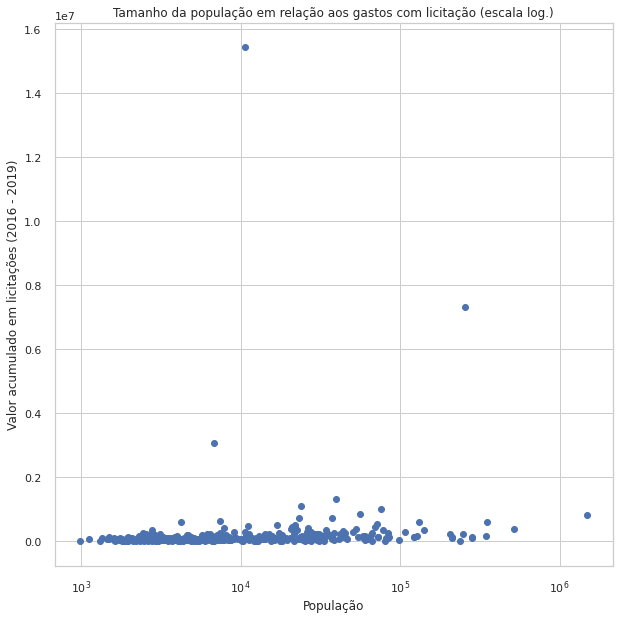

In [50]:
plt.figure(figsize=(10,10))
plt.scatter(spending_per_city["POPULAÇÃO ESTIMADA"], spending_per_city["VL_HOMOLOGADO"])
plt.title("Tamanho da população em relação aos gastos com licitação (escala log.)")
plt.xscale('log')
plt.xlabel("População")
plt.ylabel("Valor acumulado em licitações (2016 - 2019)")
plt.show()

Percebemos que há uma leve tendência a gastos maiores em municípios com populações maiores. Podemos consolidar essa tendência utilizando uma fórmula matemática chamada de **correlação de Pearson**, que é uma medida da correlação linear de duas variáveis, ou seja, ela registra o quanto uma variável específica de um conjunto de amostras cresce (ou diminui) em relação a outra variável. A fórmula é relativamente simples:

$\Large corr_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar{x}})(y_{i}-{\bar{y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar{x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar{y}})^{2}}}}} $ 

Podemos usá-la para avaliar a correlação entre os valores homologados e a população. Para isso, podemos usar o *pandas*:



In [51]:
spending_per_city[["POPULAÇÃO ESTIMADA","VL_HOMOLOGADO"]].corr()

,POPULAÇÃO ESTIMADA,VL_HOMOLOGADO
POPULAÇÃO ESTIMADA,1.000000,0.099417
VL_HOMOLOGADO,0.099417,1.000000


Temos uma correlação de Pearson de aproximadamente 0.099 para essas duas variáveis, o que mostra, como o gráfico acima já indicava, uma leve tendência a gastos maiores com licitações para municípios com mais habitantes.

Como essa tendência é bem leve, no dado existirão municípios que não seguem o padrão observado. Vamos dar uma olhada nessas amostras, normalmente chamadas de *outliers*:

In [52]:
# Municípios com maior valor acumulado em licitações
spending_per_city.sort_values("VL_HOMOLOGADO", ascending=False)

,NOME DO MUNICÍPIO,VL_HOMOLOGADO,POPULAÇÃO ESTIMADA
410,TAPERA,1.543383e+07,10577
454,VIAMÃO,7.309070e+06,256302
179,HERVAL,3.069057e+06,6814
333,ROSÁRIO DO SUL,1.327391e+06,39314
433,TRÊS PASSOS,1.103727e+06,23852
...,...,...,...
436,TUPANCI DO SUL,NaN,1459
457,VILA LÂNGARO,NaN,2080
461,VISTA GAÚCHA,NaN,2855
465,ÁGUA SANTA,NaN,3743


In [53]:
spending_per_city["VL_HOMOLOGADO"]

0       81916.317000
1      109878.710756
2       50000.965482
3       41999.395903
4      150371.823778
           ...      
462    103254.854943
463     29584.933333
464    524064.993333
465              NaN
466              NaN
Name: VL_HOMOLOGADO, Length: 467, dtype: float64

In [54]:
# Municípios com maior população
spending_per_city.sort_values("POPULAÇÃO ESTIMADA", ascending=False)

,NOME DO MUNICÍPIO,VL_HOMOLOGADO,POPULAÇÃO ESTIMADA
303,PORTO ALEGRE,813275.171248,1488252
88,CAXIAS DO SUL,375486.214600,517451
72,CANOAS,595643.252832,348208
292,PELOTAS,183539.033472,343132
345,SANTA MARIA,127455.269434,283677
...,...,...,...
84,CARLOS GOMES,120723.550000,1351
13,ANDRÉ DA ROCHA,NaN,1343
306,PORTO VERA CRUZ,30087.560920,1308
442,UNIÃO DA SERRA,83744.919259,1118


 **O município com o maior valor acumulado de licitações nesses 4 anos é Tapera**, com uma população de cerca de 10 mil habitantes, mas com gasto total em licitações de 10 milhões de reais.
Os terceiro  município com maior gasto (Herval) também é pequeno porte, com população menor que 10.000 habitantes. Isso mostra que, pelo menos neste dado analisado, municípios pequenos não terão necessariamente gastos menores em relação aos grandes.

A fim de comparação, **o maior município de RS, a capital Porto Alegre, tem um valor acumulado de aproximadamente 810 mil reais**. O segundo maior município, Caxias do Sul, possui um gasto similar, de aproximadamente 375 mil reais em compras.

Para realizar uma análise mais detalhada da relação entre os gastos e o tamanho dos municípios, precisamos agrupá-los em classes. Vamos fazer isso.

## Proporção dos gastos por tamanho de município

Para analisar a proporção de gastos de acordo com o tamanho do município, é importante realizar uma estratificação do dado original, ou seja, designar os municípios para faixas de população pré-definidas. Isso facilita o agrupamento dos municípios de acordo com seu tamanho e auxilia na análise dos dados.

Segundo o IBGE, em documento de 2017 denominado [Perfil dos Municípios Brasileiros](https://agenciadenoticias.ibge.gov.br/media/com_mediaibge/arquivos/496bb4fbf305cca806aaa167aa4f6dc8.pdf), é possível dividir os municípios brasileiros em 7 classes de tamanho de acordo com sua população, sendo elas:
* Até 5000 habitantes;
* De 5.001 a 10.000 habitantes;
* De 10.001 a 20.000 habitantes;
* De 20.001 a 50.000 habitantes;
* De 50.001 a 100.000 habitantes;
* De 100.001 a 500.000 habitantes;
* E mais de 500.000 habitantes.

Vamos checar o número de municípios do RS para cada uma dessas classes:


In [55]:
pop_per_city = dict(zip(cities_rs["NOME DO MUNICÍPIO"], cities_rs["POPULAÇÃO ESTIMADA"]))
cities_classes = []

for population in cities_rs["POPULAÇÃO ESTIMADA"]:
    if population < 5000:
        cities_classes.append("Menos de 5.000 hab.")
    elif population > 5000 and population <= 10000:
        cities_classes.append("Entre 5.0001 e 10.000 hab.")
    elif population > 10000 and population <= 20000:
        cities_classes.append("Entre 10.001 e 20.000 hab.")
    elif population > 20000 and population <= 50000:
        cities_classes.append("Entre 20.001 e 50.000 hab.")
    elif population > 50000 and population <= 100000:
        cities_classes.append("Entre 50.001 e 100.000 hab.")
    elif population > 100000 and population <= 500000:
        cities_classes.append("Entre 100.001 e 500.000 hab.")
    else:
        cities_classes.append("Mais de 500.000 hab.")

In [56]:
cities_rs["CLASSE"] = cities_classes

In [57]:
cities_classes_distrib = cities_rs.groupby("CLASSE").count().reset_index()
cities_classes_distrib

,CLASSE,UF,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA
0,Entre 10.001 e 20.000 hab.,59,59,59
1,Entre 100.001 e 500.000 hab.,17,17,17
2,Entre 20.001 e 50.000 hab.,64,64,64
3,Entre 5.0001 e 10.000 hab.,98,98,98
4,Entre 50.001 e 100.000 hab.,26,26,26
5,Mais de 500.000 hab.,2,2,2
6,Menos de 5.000 hab.,231,231,231


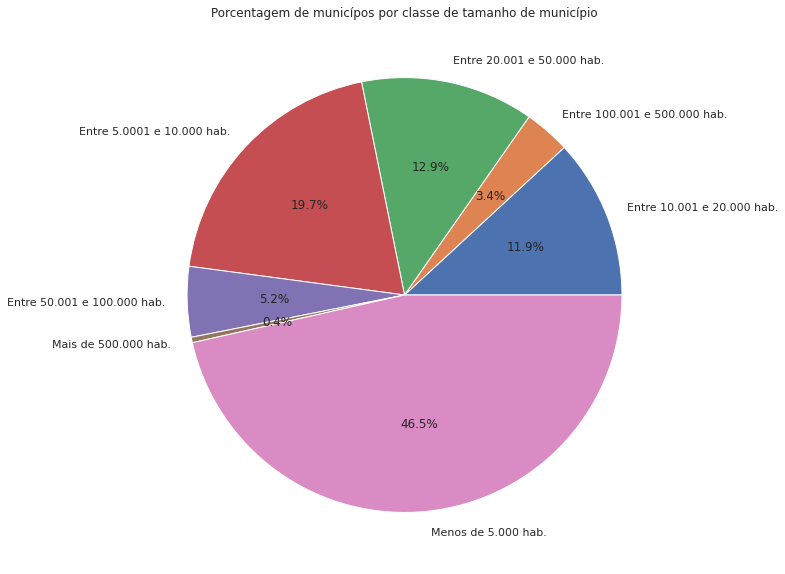

In [58]:
plt.figure(figsize=(10,10))
plt.pie(cities_classes_distrib["UF"], labels=cities_classes_distrib["CLASSE"], autopct='%1.1f%%')
plt.title("Porcentagem de municípos por classe de tamanho de município")
plt.show()

Percebe-se que mais da metade dos municípios possui menos de 10.000 habitantes. Além disso, municípios grandes, com mais de 100.000 habitantes, representam menos de 4% do total.

Agora, vamos analisar como a população do Rio Grande do Sul se distribui dentro de cada classe dessa:

In [59]:
cities_pop_distrib = cities_rs.groupby("CLASSE").sum().reset_index()
cities_pop_distrib

,CLASSE,POPULAÇÃO ESTIMADA
0,Entre 10.001 e 20.000 hab.,795655
1,Entre 100.001 e 500.000 hab.,3509708
2,Entre 20.001 e 50.000 hab.,1961170
3,Entre 5.0001 e 10.000 hab.,662243
4,Entre 50.001 e 100.000 hab.,1800340
5,Mais de 500.000 hab.,2005703
6,Menos de 5.000 hab.,688154


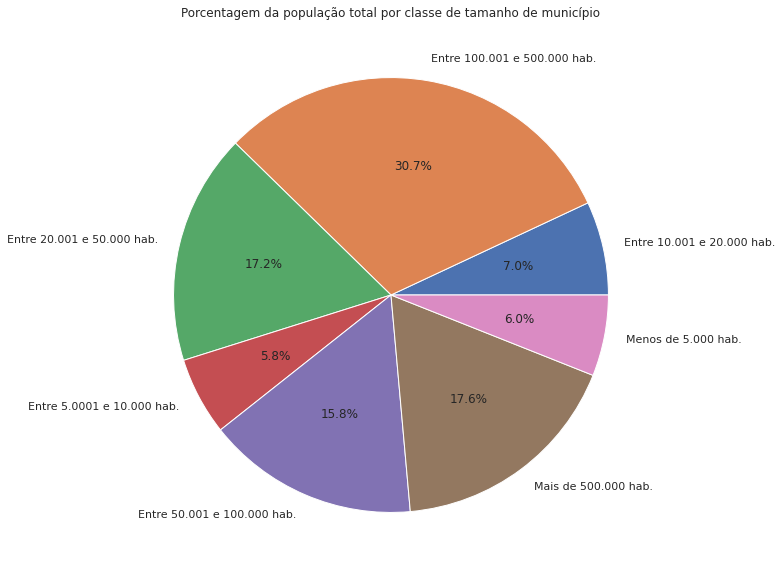

In [60]:
plt.figure(figsize=(10,10))
plt.pie(cities_pop_distrib["POPULAÇÃO ESTIMADA"], labels=cities_pop_distrib["CLASSE"],autopct='%1.1f%%' )
plt.title("Porcentagem da população total por classe de tamanho de município")
plt.show()

O gráfico acima indica que um pouco mais de um terço (64.1%) da população de RS se concentra em municípios com mais de 50.000 habitantes. Dessa forma, se for levado em conta apenas o critério populacional, é esperado que os gastos com licitações originados dessa fatia dos municípios represente uma parte considerável do total gasto também. Será que essa hipótese é verdadeira? Vamos analisar:

In [61]:
bids

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,VL_LICITACAO,VL_HOMOLOGADO,NR_PROCESSO,NOME DO MUNICÍPIO
0,84100,PM DE ESPERANÇA DO SUL,4.00,2016,CNV,11216.50,NaN,003,ESPERANÇA DO SUL
1,82701,CM DE XANGRI-LÁ,1.00,2016,PRP,NaN,NaN,01,XANGRI-LÁ
2,84100,PM DE ESPERANÇA DO SUL,6.00,2016,CNV,59810.60,NaN,005,ESPERANÇA DO SUL
3,53100,PM DE NOVA PALMA,3.00,2016,PRP,251.70,NaN,07,NOVA PALMA
4,86800,PM DE BOA VISTA DO SUL,3.00,2016,PRP,31384.90,NaN,004,BOA VISTA DO SUL
...,...,...,...,...,...,...,...,...,...
82400,82901,CM DE ARARICÁ,29.00,2019,PRD,92.91,NaN,029,ARARICÁ
82401,82901,CM DE ARARICÁ,28.00,2019,PRD,57.80,NaN,028,ARARICÁ
82402,2304,BRIGADA MILITAR,84509.55,2019,PRI,949000.00,NaN,19/1203-0020582-,None
82403,56900,PM DE SANTA MARIA,39.00,2019,PRI,76810.50,NaN,214,SANTA MARIA


In [62]:
cities_rs

,UF,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA,CLASSE
0,RS,ACEGUÁ,4942,Menos de 5.000 hab.
1,RS,ÁGUA SANTA,3743,Menos de 5.000 hab.
2,RS,AGUDO,16401,Entre 10.001 e 20.000 hab.
3,RS,AJURICABA,6987,Entre 5.0001 e 10.000 hab.
4,RS,ALECRIM,5827,Entre 5.0001 e 10.000 hab.
...,...,...,...,...
492,RS,VISTA ALEGRE DO PRATA,1557,Menos de 5.000 hab.
493,RS,VISTA GAÚCHA,2855,Menos de 5.000 hab.
494,RS,VITÓRIA DAS MISSÕES,3092,Menos de 5.000 hab.
495,RS,WESTFÁLIA,3031,Menos de 5.000 hab.


In [63]:
bids_with_city = pd.merge(bids[["NOME DO MUNICÍPIO", "VL_HOMOLOGADO", "ANO_LICITACAO"]], cities_rs[["NOME DO MUNICÍPIO", "CLASSE", "POPULAÇÃO ESTIMADA"]], on="NOME DO MUNICÍPIO")

In [64]:
spending_per_city_class = bids_with_city.groupby("CLASSE").sum().reset_index()

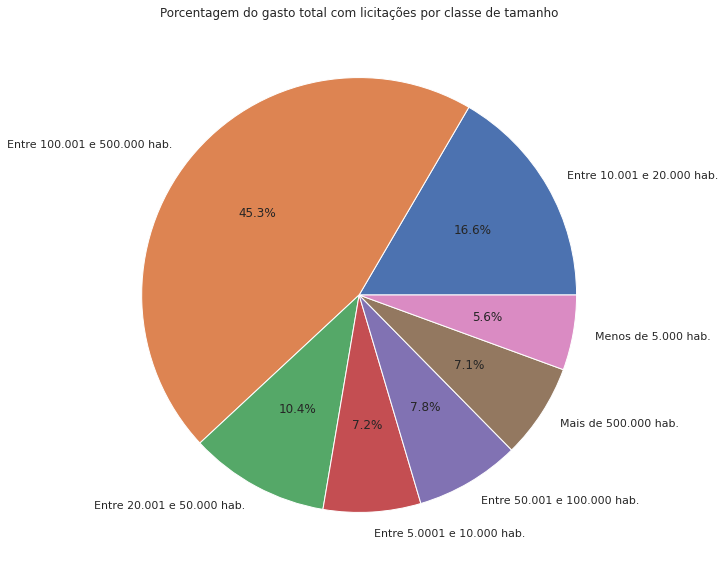

In [65]:
plt.figure(figsize=(10,10))
plt.title("Porcentagem do gasto total com licitações por classe de tamanho")
plt.pie(spending_per_city_class["VL_HOMOLOGADO"], 
        labels=spending_per_city_class["CLASSE"], 
        autopct='%1.1f%%')
plt.show()

O resultado mostrado com o gráfico acima é condizente com a hipótese levantada anteriormente: municípios com população maior representam a maior parte do gasto com licitações de compras. 

Essa conclusão fica mais clara ao se plotar os dois gráficos acima como um único gráfico de barras:



In [66]:
# Ordenar dataframes por classes -> Da menor população para maior
labels = ["Menos de 5.000 hab.",
            "Entre 5.0001 e 10.000 hab.",
            "Entre 10.001 e 20.000 hab.",
            "Entre 20.001 e 50.000 hab.",
            "Entre 50.001 e 100.000 hab.",
            "Entre 100.001 e 500.000 hab.",
            "Mais de 500.000 hab."]

cities_pop_distrib = cities_pop_distrib.set_index("CLASSE").loc[labels].reset_index()
spending_per_city_class = spending_per_city_class.set_index("CLASSE").loc[labels].reset_index()

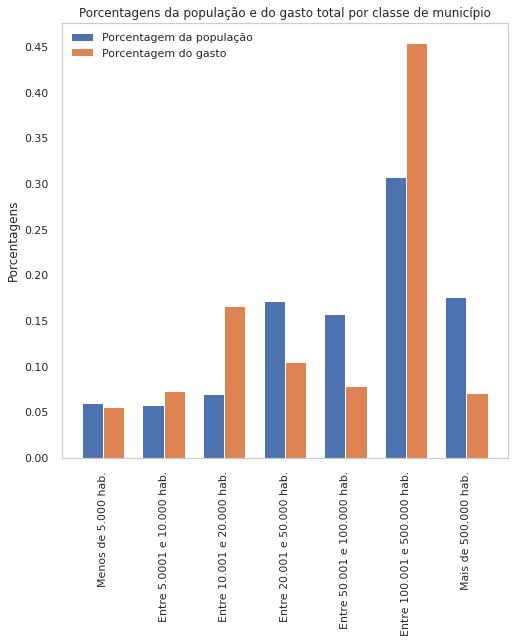

In [67]:
labels = ["Menos de 5.000 hab.",
            "Entre 5.0001 e 10.000 hab.",
            "Entre 10.001 e 20.000 hab.",
            "Entre 20.001 e 50.000 hab.",
            "Entre 50.001 e 100.000 hab.",
            "Entre 100.001 e 500.000 hab.",
            "Mais de 500.000 hab."]

labels = cities_pop_distrib["CLASSE"]
total_pop = cities_pop_distrib["POPULAÇÃO ESTIMADA"].sum()
total_spending = spending_per_city_class["VL_HOMOLOGADO"].sum()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,8))

    
ax.bar(x - width/2, 
       cities_pop_distrib["POPULAÇÃO ESTIMADA"]/total_pop, 
       width, 
       label="Porcentagem da população")
ax.bar(x + width/2, 
       spending_per_city_class["VL_HOMOLOGADO"]/total_spending, 
       width, 
       label='Porcentagem do gasto')

ax.set_ylabel('Porcentagens')
ax.set_yticks(np.arange(0, 0.5, 0.05))
ax.set_title('Porcentagens da população e do gasto total por classe de município')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()
ax.grid()
plt.show()

Vemos acima que, apesar de não haver uma relação exata entre a faixa de tamanho do município e seu gasto, a diferença entre os dois valores nunca passa de 20%. Dessa maneira, é possível sim afirmar que o tamanho populacional está intimamente relacionado com a proporção dos gastos.

Um segundo ponto a se analisar, trazendo um maior detalhamento do que foi mostrado acima, são os valores percentuais de cada classe separados por ano, como mostrado abaixo:

In [68]:
spendings_per_year = bids_with_city.groupby("ANO_LICITACAO").sum().reset_index()
spendings_per_year

,ANO_LICITACAO,VL_HOMOLOGADO,POPULAÇÃO ESTIMADA
0,2016,5.662068e+09,958869960
1,2017,1.841222e+09,1568234993
2,2018,1.677622e+09,1542777422
3,2019,3.036684e+09,1711359097


In [69]:
spendings_per_year_per_class = bids_with_city.groupby(["ANO_LICITACAO", "CLASSE"]).sum().reset_index()
spendings_per_year_per_class

,ANO_LICITACAO,CLASSE,VL_HOMOLOGADO,POPULAÇÃO ESTIMADA
0,2016,Entre 10.001 e 20.000 hab.,5.538982e+07,18948333
1,2016,Entre 100.001 e 500.000 hab.,5.066227e+09,414475820
2,2016,Entre 20.001 e 50.000 hab.,1.834155e+08,85038384
3,2016,Entre 5.0001 e 10.000 hab.,4.766083e+07,11267190
4,2016,Entre 50.001 e 100.000 hab.,1.330642e+08,93966932
5,2016,Mais de 500.000 hab.,1.040940e+08,325660597
6,2016,Menos de 5.000 hab.,7.221659e+07,9512704
7,2017,Entre 10.001 e 20.000 hab.,1.124299e+08,35515059
8,2017,Entre 100.001 e 500.000 hab.,1.793875e+08,566455335
9,2017,Entre 20.001 e 50.000 hab.,4.245880e+08,135170543


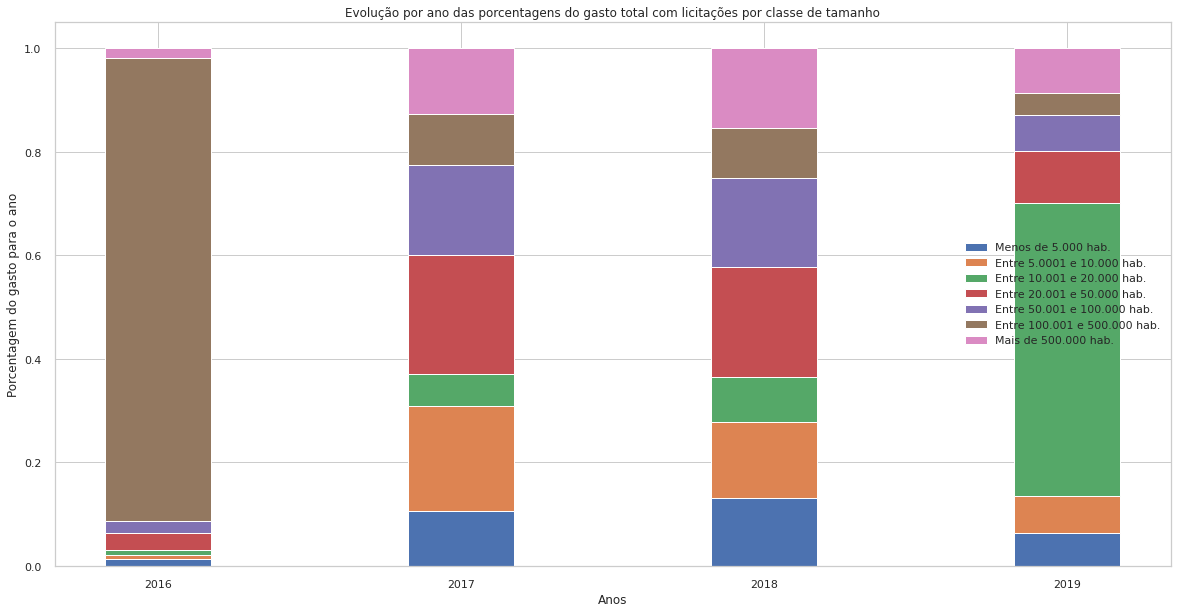

In [70]:

labels = [str(year) for year in range(2016, 2020)]
classes =  ["Menos de 5.000 hab.",
            "Entre 5.0001 e 10.000 hab.",
            "Entre 10.001 e 20.000 hab.",
            "Entre 20.001 e 50.000 hab.",
            "Entre 50.001 e 100.000 hab.",
            "Entre 100.001 e 500.000 hab.",
            "Mais de 500.000 hab."]

fig, ax = plt.subplots(figsize=(20,10))
bottom = np.zeros(4)

for class_ in classes:
    spendings_per_class = spendings_per_year_per_class[
        spendings_per_year_per_class["CLASSE"] == class_]["VL_HOMOLOGADO"].values
    ax.bar(labels, 
           (spendings_per_class/spendings_per_year["VL_HOMOLOGADO"].values), 
           width,
           label=class_,
          bottom=bottom)
    bottom += spendings_per_class/spendings_per_year["VL_HOMOLOGADO"].values
    

ax.set_ylabel('Porcentagem do gasto para o ano')
ax.set_xlabel("Anos")
ax.set_title('Evolução por ano das porcentagens do gasto total com licitações por classe de tamanho')
ax.legend()

plt.show()

Por meio do gráfico acima, dois fenômemos ficam claros:
* Os municípios com população entre 100.001 e 500.000 representaram em 2016 quase que a totalidade dos gastos com as licitações;
* Em 2019, foram os municípios com população entre 10.001 e 20.000 que se tornaram os líderes nos gastos.

Uma hipótese pode ser criada a partir dessas duas informações e do seu suposto relacionamento com o resultado obtido no início do notebook, em que os valores homologados em 2016 foram 5 vezes maiores do que os registrados em 2017 e que os valores para 2018 represetavam a metade dos de 2019: talvez o crescimento do gasto em 2016 e 2019 seja causado por licitações específicas dentro dessas duas classes respectivamente.

Nessa seção, ainda não está sendo feito uma análise dos itens comprados. Dessa forma, vamos tentar encontrar algum padrão de compra que identifique o que causou esse crescimento tomando como base os municípios pertecentes a essas classes e seus gastos nesses anos.

## Avaliação das compras para os municípios com pop. entre 100.001 e 500.000 habitantes em 2016

In [71]:
cities_100k_to_500k_2016 = bids_with_city[(bids_with_city["CLASSE"] == "Entre 100.001 e 500.000 hab.") & 
                                          (bids_with_city["ANO_LICITACAO"] == 2016)].reset_index(drop=True)
cities_100k_to_500k_2016

,NOME DO MUNICÍPIO,VL_HOMOLOGADO,ANO_LICITACAO,CLASSE,POPULAÇÃO ESTIMADA
0,SAPUCAIA DO SUL,NaN,2016,Entre 100.001 e 500.000 hab.,141808
1,SAPUCAIA DO SUL,NaN,2016,Entre 100.001 e 500.000 hab.,141808
2,SAPUCAIA DO SUL,NaN,2016,Entre 100.001 e 500.000 hab.,141808
3,SAPUCAIA DO SUL,2905190.20,2016,Entre 100.001 e 500.000 hab.,141808
4,SAPUCAIA DO SUL,8179.00,2016,Entre 100.001 e 500.000 hab.,141808
...,...,...,...,...,...
1709,VIAMÃO,6440.00,2016,Entre 100.001 e 500.000 hab.,256302
1710,VIAMÃO,744565.70,2016,Entre 100.001 e 500.000 hab.,256302
1711,VIAMÃO,35013636.99,2016,Entre 100.001 e 500.000 hab.,256302
1712,VIAMÃO,103500.00,2016,Entre 100.001 e 500.000 hab.,256302


In [72]:
cities_100k_to_500k_2016 = cities_100k_to_500k_2016.sort_values("VL_HOMOLOGADO", ascending=False)

In [73]:
cities_100k_to_500k_2016

,NOME DO MUNICÍPIO,VL_HOMOLOGADO,ANO_LICITACAO,CLASSE,POPULAÇÃO ESTIMADA
1530,VIAMÃO,4.686187e+09,2016,Entre 100.001 e 500.000 hab.,256302
1543,VIAMÃO,1.923684e+08,2016,Entre 100.001 e 500.000 hab.,256302
1711,VIAMÃO,3.501364e+07,2016,Entre 100.001 e 500.000 hab.,256302
190,NOVO HAMBURGO,1.186885e+07,2016,Entre 100.001 e 500.000 hab.,247032
1665,VIAMÃO,1.074075e+07,2016,Entre 100.001 e 500.000 hab.,256302
...,...,...,...,...,...
1383,BAGÉ,NaN,2016,Entre 100.001 e 500.000 hab.,121335
1386,BAGÉ,NaN,2016,Entre 100.001 e 500.000 hab.,121335
1387,BAGÉ,NaN,2016,Entre 100.001 e 500.000 hab.,121335
1388,BAGÉ,NaN,2016,Entre 100.001 e 500.000 hab.,121335


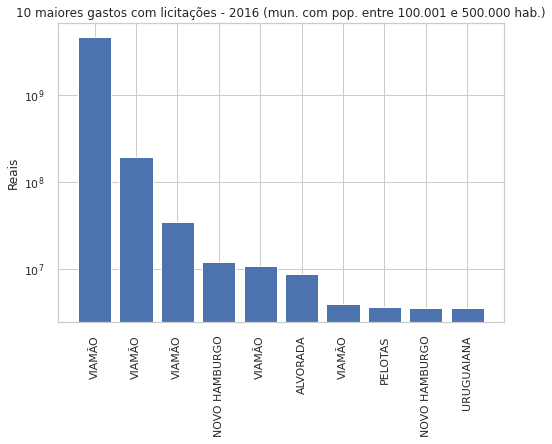

In [74]:
plt.bar(list(range(0,10)),
        cities_100k_to_500k_2016["VL_HOMOLOGADO"][:10])
plt.title("10 maiores gastos com licitações - 2016 (mun. com pop. entre 100.001 e 500.000 hab.)")
plt.xticks(list(range(0,10)), cities_100k_to_500k_2016["NOME DO MUNICÍPIO"][:10].values, rotation=90)
plt.yscale('log')
plt.ylabel("Reais")
plt.show()

Vemos pelo gráfico acima que o município de Viamão é responsável por 5 dos 10 valores homologados de licitação entre os municípios com população entre 100.001 e 500.000 habitantes. O maior dos valores, cerca de 4.6 bilhões de  reais, representa sozinho mais de 80% do gasto total de 2016! 

Os outros valores, como se vê acima, ficam dentro da faixa dos milhões de reais. A conclusão que se chega com isso é que tanto o ponto fora da curva dos gastos em 2016 quanto a esmagadora proporção de gastos de 2016 ser dos municípos na faixa de população de 100.001 a 500.000 habitantes se deve majoritariamente por uma única licitação do município de Viamão! Mais adiante, quando analisarmos os itens licitados, vamos tentar checar se há algum produto diferente ou especial que justifique esse gasto exorbitante.

## Avaliação das compras para os municípios com pop. entre 10.001 e 20.000 habitantes em 2019

In [75]:
cities_10k_to_20k_2019 = bids_with_city[(bids_with_city["CLASSE"] == "Entre 10.001 e 20.000 hab.") & 
                                          (bids_with_city["ANO_LICITACAO"] == 2019)].reset_index(drop=True)
cities_10k_to_20k_2019

,NOME DO MUNICÍPIO,VL_HOMOLOGADO,ANO_LICITACAO,CLASSE,POPULAÇÃO ESTIMADA
0,XANGRI-LÁ,NaN,2019,Entre 10.001 e 20.000 hab.,16775
1,XANGRI-LÁ,NaN,2019,Entre 10.001 e 20.000 hab.,16775
2,XANGRI-LÁ,NaN,2019,Entre 10.001 e 20.000 hab.,16775
3,XANGRI-LÁ,NaN,2019,Entre 10.001 e 20.000 hab.,16775
4,XANGRI-LÁ,NaN,2019,Entre 10.001 e 20.000 hab.,16775
...,...,...,...,...,...
2100,BARROS CASSAL,154499.5,2019,Entre 10.001 e 20.000 hab.,11182
2101,BARROS CASSAL,859000.0,2019,Entre 10.001 e 20.000 hab.,11182
2102,BARROS CASSAL,60754.5,2019,Entre 10.001 e 20.000 hab.,11182
2103,BARROS CASSAL,397500.0,2019,Entre 10.001 e 20.000 hab.,11182


In [76]:
cities_10k_to_20k_2019 = cities_10k_to_20k_2019.sort_values("VL_HOMOLOGADO", ascending=False)

In [77]:
cities_10k_to_20k_2019

,NOME DO MUNICÍPIO,VL_HOMOLOGADO,ANO_LICITACAO,CLASSE,POPULAÇÃO ESTIMADA
1749,TAPERA,1.583767e+09,2019,Entre 10.001 e 20.000 hab.,10577
1637,TAPES,1.039074e+07,2019,Entre 10.001 e 20.000 hab.,17332
1609,ANTÔNIO PRADO,3.265000e+06,2019,Entre 10.001 e 20.000 hab.,13045
2095,BARROS CASSAL,2.983600e+06,2019,Entre 10.001 e 20.000 hab.,11182
1635,TAPES,2.623290e+06,2019,Entre 10.001 e 20.000 hab.,17332
...,...,...,...,...,...
2088,RESTINGA SÊCA,NaN,2019,Entre 10.001 e 20.000 hab.,15744
2089,RESTINGA SÊCA,NaN,2019,Entre 10.001 e 20.000 hab.,15744
2090,RESTINGA SÊCA,NaN,2019,Entre 10.001 e 20.000 hab.,15744
2091,RESTINGA SÊCA,NaN,2019,Entre 10.001 e 20.000 hab.,15744


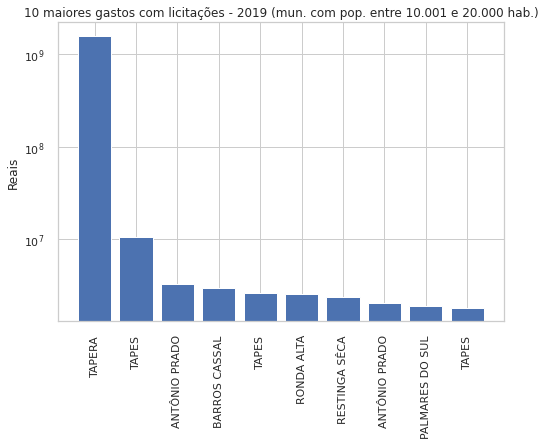

In [78]:
plt.bar(list(range(0,10)),
        cities_10k_to_20k_2019["VL_HOMOLOGADO"][:10])
plt.title("10 maiores gastos com licitações - 2019 (mun. com pop. entre 10.001 e 20.000 hab.)")
plt.xticks(list(range(0,10)), cities_10k_to_20k_2019["NOME DO MUNICÍPIO"][:10].values, rotation=90)
plt.yscale('log')
plt.ylabel("Reais")
plt.show()

Como para o caso de Viamão, temos mais uma vez um município com um gasto que tem uma proporção bem maior que os demais da sua classe. Dessa vez se trata de Tapera, que em 2019 teve uma licitação de compras com valor homologado de um pouco mais de 1.5 bilhão de reais. Esse valor sozinho representa quase que a metade do valor total gasto em 2019.

Como no caso anterior, iremos analisar essa situação mais minunciosamente ao checar os itens licitados.

# Análise dos itens comprados

A última seção desse notebook tem o objetivo de identificar padrões na descrição dos itens comprados nas licitações. É importante destacar que por esse dado se tratar de um campo sem um formato bem definido, isto é, de escrita livre, será necessário utilizar algumas técnicas de NLP a fim de auxiliar na análise dos itens.  

Porém, antes de iniciar esse processo, é necessário consolidar os dois datasets existentes (licitações e itens) em um só. Para isso, cinco campos de identificação serão utilizados: 
* *CD_ORGAO*;
* *NR_LICITACAO*;
* *ANO_LICITACAO*;
* *CD_TIPO_MODALIDADE*;
* *NR_PROCESSO*.

In [79]:
bids_with_items = pd.merge(bids, 
                           items, 
                           on=["CD_ORGAO", "NR_LICITACAO", "ANO_LICITACAO", "CD_TIPO_MODALIDADE", "NR_PROCESSO"])
bids_with_items.tail()

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,VL_LICITACAO,VL_HOMOLOGADO,NR_PROCESSO,NOME DO MUNICÍPIO,DS_OBJETO
82400,82901,CM DE ARARICÁ,29.00,2019,PRD,92.91,NaN,029,ARARICÁ,aquisição de materiais de limpeza
82401,82901,CM DE ARARICÁ,28.00,2019,PRD,57.80,NaN,028,ARARICÁ,aquisição de materiais de limpeza para esta ca...
82402,2304,BRIGADA MILITAR,84509.55,2019,PRI,949000.00,NaN,19/1203-0020582-,None,100.000 (cem mil) unidades munições CBC 40sw C...
82403,56900,PM DE SANTA MARIA,39.00,2019,PRI,76810.50,NaN,214,SANTA MARIA,Fornecimento de passagem escolar urbana
82404,56900,PM DE SANTA MARIA,19.00,2019,PRE,7088.52,NaN,136,SANTA MARIA,"Aquisição de material educativo, esportivo e v..."


Agora que os dois datasets estão juntos, iremos passar para a etapa de pré-processamento das descrições de objetos das licitações. 

O intuito dessa etapa é remover palavras ou termos que são bastante comums na língua portugueza, porém não tão relevantes para se entender o significado princial de um texto ou de uma frase, como por exemplo preposições e conjuções.

Tomando como exemplo a primeira amostra da célula de cima, se as duas preposições "de" fossem removida ("aquisição materiais limpeza"), diminuiríamos em 40% a quantidade de palavras do texto e ainda sim seria possível saber que a licitação se trata de uma aquisição de materiais de limpeza. 

Além da remoção dessas palavras, geralmente chamadas de *stopwords*, é importante também colocar o texto inteiro em minúsculo e retirar acentos e pontuação. Isso tem o objetivo de evitar que os algoritmos que iremos utilizar para identificar padrões não tratem palavras que no fundo são iguais como sendo diferentes. Exemplos disso ocorrem quando uma palavra inicia a descrição e tem sua primeira letra maiúscula e quando é usada ao longo do texto ("Aquisição" e "aquisição", por exemplo) ou quando há duas ocorrências da mesma palavra, mas uma está acentuada e a outra não ("prédio" e "predio").

Números também serão removidos da análise, pois, apesar de nos darem ideia do volume comprado nos casos em que aparecem, não dão indícios do que se trata cada compra.

Resumindo, o pré-processamento ocorrerá na seguinte sequência:
* 1) Normalização do texto - Troca de todos os caracteres em maiúsculo por minúsculo e remoção de acentos, pontuação e números;
* 2) Normalização das *stopwords*;
* 3) Remoção de *stopwords*.



In [80]:
stop_words = stopwords.words('portuguese')
stop_words = [unidecode.unidecode(word) for word in stop_words]

def preprocess_text(text):
    # colocar em caixa baixa
    preprocessed_text = text.str.lower()
    
    # remover pontuação
    preprocessed_text = preprocessed_text.str.replace(r'[^\w\s]','', regex=True)
    
    # remover números
    preprocessed_text = preprocessed_text.str.replace(r'\d+','', regex=True)

    # remover acentos
    preprocessed_text = preprocessed_text.apply(unidecode.unidecode)

    # remover stopwords
    preprocessed_text = preprocessed_text.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))    

    return preprocessed_text

In [81]:
preprocessed_text = preprocess_text(bids_with_items["DS_OBJETO"])
preprocessed_text

0                                aquisicao merenda escolar
1              aquisicao protocoladora fragmentadora papel
2         aquisicao materiais limpeza diversas secretarias
3                                 aquisicao tubos concreto
4                                 aquisicao tubos concreto
                               ...                        
82400                          aquisicao materiais limpeza
82401         aquisicao materiais limpeza casa legislativa
82402    cem mil unidades municoes cbc sw cxpo gr coope...
82403                 fornecimento passagem escolar urbana
82404    aquisicao material educativo esportivo ventila...
Name: DS_OBJETO, Length: 82405, dtype: object

## Análise das palavras mais frequentes

Vamos plotar uma nuvem de palavras, onde palavras com a fonte maior representam maior frequência, e também um gráfico de barras com a frequência das 50 palavras mais frequentes:


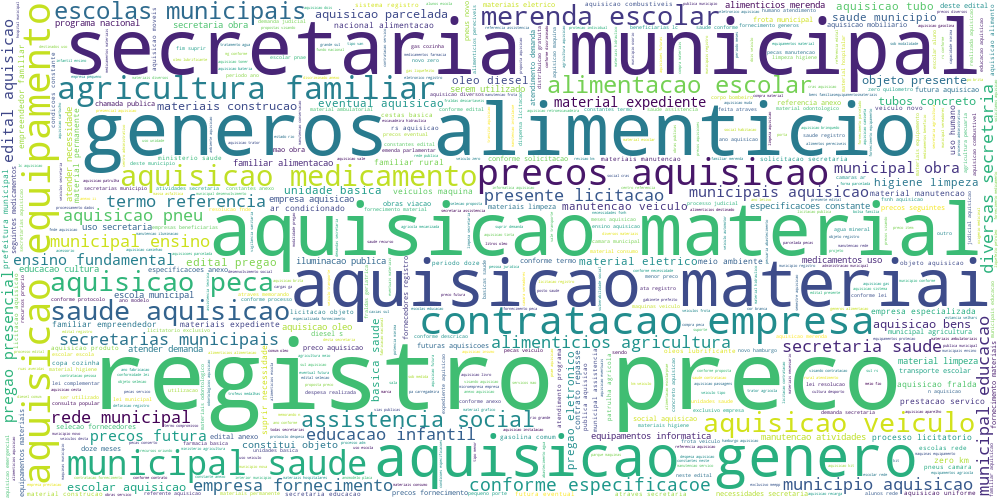

In [82]:
preprocessed_text_string = ' '.join(list(preprocessed_text.values))
wordcloud = WordCloud(height=500,width=1000, 
                      background_color="white", 
                      max_words=5000, contour_width=3, 
                      contour_color='steelblue')
wordcloud.generate(preprocessed_text_string)
wordcloud.to_image()

In [83]:
def get_words_frequency(text):
    word_freq = {}

    for doc in text.values:
        for word in doc.split():
            if not word_freq.get(word):
                word_freq[word] = 1
            else:
                word_freq[word] += 1
    # Ordena palavras por frequência
    word_freq = dict(sorted(word_freq.items(), key=lambda w:w[1], reverse=True))
    return word_freq

In [84]:
word_freq = get_words_frequency(preprocessed_text)

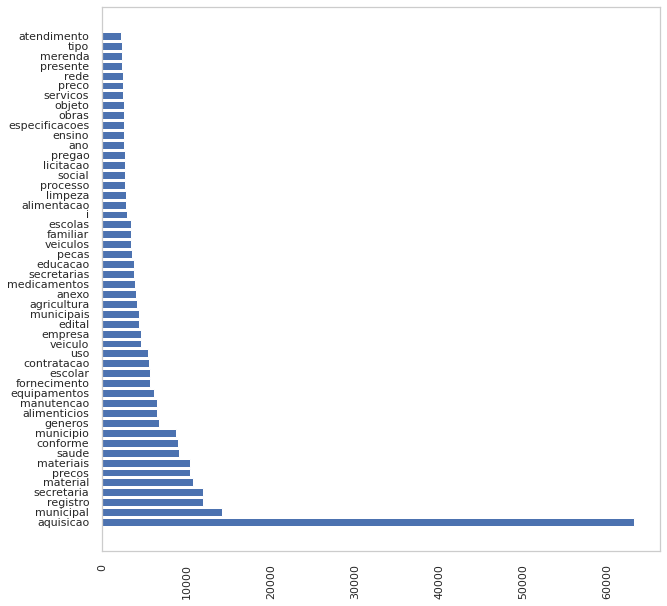

In [85]:
plt.figure(figsize=(10,10))
plt.barh(list(word_freq.keys())[:50], list(word_freq.values())[:50])
plt.xticks(rotation=90)
plt.grid()
plt.show()

Vemos que palavras como "aquisição", "municipal" e "secretaria", que fazem todo sentido no contexto de compras, são bastante frequentes, porém não nos informam muito sobre do que se trata uma compra. Vamos remover esses termos:


In [86]:
new_stop_words = ["aquisicao", "municipal", "registro", "secretaria", "secretarias", "conforme", "municipio", 
                  "generos","municipais", "edital", "anexo","i", "ii", "licitacao", "pregao","ano", "adm", "uso", 
                  "x", "rs" ,"preco", "precos"]

preprocessed_text = preprocessed_text.apply(lambda x: " ".join(x for x in x.split() if x not in new_stop_words))    


In [87]:
new_word_freq = get_words_frequency(preprocessed_text)

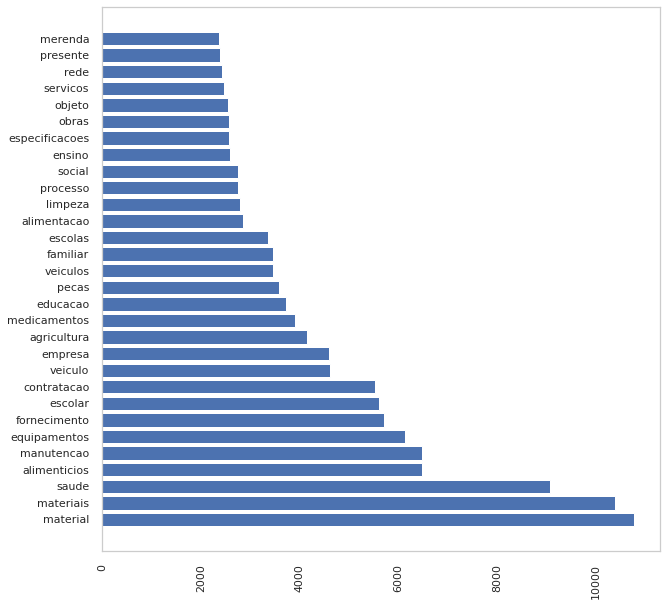

In [88]:
plt.figure(figsize=(10,10))
plt.barh(list(new_word_freq.keys())[:30], list(new_word_freq.values())[:30])
plt.xticks(rotation=90)
plt.grid()
plt.show()

Agora vemos que as palavras mais frequentes nos dão ideia do que se trata a licitação. Nesse contexto, podemos usar alguns métodos para auxiliar na identificação de termos relevantes em cada amostra sem que tenhamos que analisar amostra por amostra. Um deles é o TF-IDF. Vamos ver do que ele se trata:

## Usando TF-Idf

Uma maneira de medir a importância de uma palavra em um texto ou documento é usando uma técnica conhecida como TF-IDF. Esse método permite calcular a relevância de uma palavra por meio da seguinte fórmula:

$$ \text{TF-IDF} = TF(p) \cdot  IDF(p) \:\: \text{onde:}
\\\
 TF(p) = \frac{\text{Núm. de vezes que uma palavra p aparece em um documento}}{\text{Núm. de palavras no documento}} 
 \\\
 IDF(p) = \ln{\frac{\text{Núm. total de documentos}}{\text{Núm. de documentos que contêm a palavra p}}}
$$

Um documento se trata de um registro ou linha do nosso dado. Por meio desse método, podemos transformar todas as descrições de objeto de licitação em vetores com valores numéricos. Vamos fazer isso:

In [89]:
tfidf = TfidfVectorizer().fit(preprocessed_text)
tfidf_vectors = tfidf.transform(preprocessed_text)
tfidf_vectors

<82405x30791 sparse matrix of type '<class 'numpy.float64'>'
	with 673059 stored elements in Compressed Sparse Row format>

Agora que temos os vetores, é possível identicar as palavras que possuem o maior valor de TFIDF em cada descrição. Na variável *tfidf* temos guardado o vocabulário de todo o texto que estamos analisando, ou seja, o conjunto de todas as palavras distintas existentes em nosso dado após o pré-processamento:


In [180]:
list(tfidf.vocabulary_.items())[:10]

[('merenda', 18422),
 ('escolar', 10446),
 ('protocoladora', 23869),
 ('fragmentadora', 12424),
 ('papel', 21390),
 ('materiais', 17963),
 ('limpeza', 16973),
 ('diversas', 8824),
 ('tubos', 29124),
 ('concreto', 6366)]

Utilizando o valor dado pelo TF-IDF para cada amostra e esse vocabulário, podemos encontrar a palavra mais importante para cada amostra. Vamos ver um exemplo:

In [91]:
bids_with_items.loc[10]["DS_OBJETO"]

'Registro de preços de gêneros alimentícios para merenda escolar'

O texto pré-processado é:

In [92]:
preprocessed_text[10]

'alimenticios merenda escolar'

E seu termo "mais importante" de acordo com o TFIDF:

In [93]:
most_important_term_10 = tfidf_vectors[10].toarray()[0].argmax()

{i:tfidf.vocabulary_[i] for i in tfidf.vocabulary_ if tfidf.vocabulary_[i] == most_important_term_10}

{'merenda': 18422}

Apesar dessa abordagem ser interessante, ela possui dois problemas básicos:
* Nem sempre o termo com o maior valor de TFIDF realmente identificará de maneira categórica do que se trata a licitação;
* É custoso em termos de memória e tempo de processamento encontrar o termo mais relevante para os 82405 documentos.

Sendo assim, como primeira tentativa de encontrar padrões de gastos, podemos usar um algoritmo não supervisionado, ou seja, onde o objetivo é identificar padrões num conjunto de dados sem rótulos ou classes. Um desses algoritmos se chama KMeans. 


## Usando KMeans


O KMeans tem o objetivo de agrupar nossos vetores, que podem ser pensados em pontos n-dimensionais (no nosso caso, 30811-dimensional, algo difícil de imaginar, mas possível, matematicamente falando) em grupos que compartilham características semelhantes. Que características são essas? Os valores armazenados nos vetores.

Se pensarmos em duas dimensões, teríamos vetores no formato (x, y), ou seja, pontos em um plano. Pensando em um exemplo, pode-se citar o dado clássico da área de Machine Learning composto de medidas de flores *Iris*. Ao plotar o comprimento das pétalas (nosso x) em relação à largura (o y), obtemos um resultado similar a:

![img](https://blog.galvanize.com/wp-content/uploads/2015/11/VOpVlko1-1.png)

No nosso caso, a ideia é a mesma, porém não sabemos a priori o número de classes nas quais as descrições aparecem (no caso das flores, são 3). E o KMeans será responsável por agrupar os dados de forma que descrições semelhantes fiquem mais próximas (*clusterizadas*).

Mas como ele faz isso? A matemática é (levemente) complexa, mas basicamente o algoritmo, com o número de grupos (ou *clusters*) determinados previamente, tem o objetivo de encontrar os centros desses grupos, conhecidos como centróides. 

Para realizar isso de uma maneira que mantenha os grupos coerentes, ou seja, que amostras similares fiquem mais próximas e amostras discrepantes afastadas, o algoritmo busca minizar uma medida chamada *inércia*. A inércia representa a soma da diferenças entre a localização de cada ponto (ou vetore) do *cluster* e a médias desses pontos. Ou seja, se o *cluster* não estiver coeso, teremos uma inércia alta e provavelmente há muitas amostras que estão designadas para ele que na verdade pertecem a outro *cluster*.

Como ainda não sabemos o número correto de supostos grupos de descrições que existem, podemos executar o algoritmo algumas vezes com diversos números pré-determinados de grupos e avaliar o resultado que possuiu a melhor coerência. Vamos realizar isso:

In [94]:
sum_of_squared_distances = []
possible_n_cluters = range(5, 15)

for n_clusters_value in possible_n_cluters:
    print(n_clusters_value)
    km = KMeans(random_state=42, n_clusters=n_clusters_value)
    km = km.fit(tfidf_vectors)
    sum_of_squared_distances.append(km.inertia_)

5
6
7
8
9
10
11
12
13
14


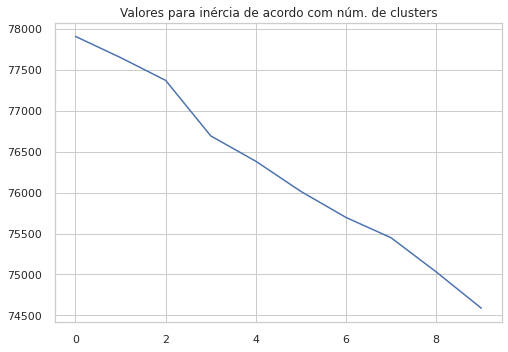

In [95]:
plt.plot(sum_of_squared_distances)
plt.title("Valores para inércia de acordo com núm. de clusters")
plt.show()

Mesmo usando um número bem grande de clusters, ainda sim a inércia fica com um valor muito elevado. Se continuarmos tentando um número maior de clusters, vamos encontrar um valor ótimo, mas teríamos tantos grupos que a tarefa de encontrar um padrão de acordo com os vetores TF-IDF das descrições ficaria bem complexa. Apesar do resultado não tere sido o esperado, vamos plotar os agrupamentos descobertos em um gráfico. Para isso, é necessário utilizar uma técnica chamada de redução de dimensionalidade. Mas por quê?

Como dito anteriormente, cada amostra gerada pelo TF-IDF possui milhares de dimensões e só conseguimos visualizar gráficos com no máximo 3 dimensões. Por conta disso, existem algoritmos que permitem capturar as dimensões mais relevantes para cada ponto n-dimensional e dessa forma, transformar as n dimensões existentes originalmente em 2 ou 3, o que permite plotar um gráfico.

Um desses algoritmos se chama t-SNE (t-distributed Stochastic Neighborg Embedding). Seu funcionamento, explicado de maneira superficial, se baseia no seguinte:
* Inicialmete, a similaridade entre todos os pares de pontos existentes é medida. O cálculo dessa similaridade é feito tomando a probabilidade de um ponto *a* considerar um ponto *b* seu vizinho (ou seja, pertecente ao mesmo grupo) tomando como base uma distribuição normal centrada em *a*. Explicando de outra maneira, quanto mais próximos os pontos *a* e *b* são originalmente, mais provável é a chance de *a* considerar *b* um vizinho e mais similares eles são considerados;
* Após se calcular uma tabela com a similaridade calculada para cada par de pontos, se projeta os pontos em posições aleatórias. Novamente se calcula a similaridade entre os pontos, mas desta vez se usando uma distribuição t. O objetivo do algoritmo é mover cada ponto de maneira incremental a fim de, ao final de *n* iterações, a nova tabela gerada de similaridades entre os pontos seja o mais similar o possível com a tabela original.

O segundo algoritmo que será usado é o PCA (Principal Component Analysis). O objetivo do PCA também é realizar redução de dimensionalidade, mas seu funcionamento se baseia na descoberta das dimensões mais relevantes (os componentes principais) para o conjunto de pontos passados. As dimensões mais relevantes são encontradas levando em conta as direções onde há a maior variância entre os pontos.

Como o foco do PCA é capturar a estrutura global dos pontos e o do t-SNE avalia a similaride em si entre eles, podemos reduzir a dimensionalidade inicialmente com o primeiro e usar seu resultado como entrada do segundo, reduzindo o tempo computacional.

Agora, vamos utilizar esses algoritmo para visualizar os cluster sugeridos pelo KMeans usando 10 clusters:



In [96]:
km = KMeans(random_state=42, n_clusters=10)
km = km.fit(tfidf_vectors)

kmeans_labels = km.predict(tfidf_vectors)

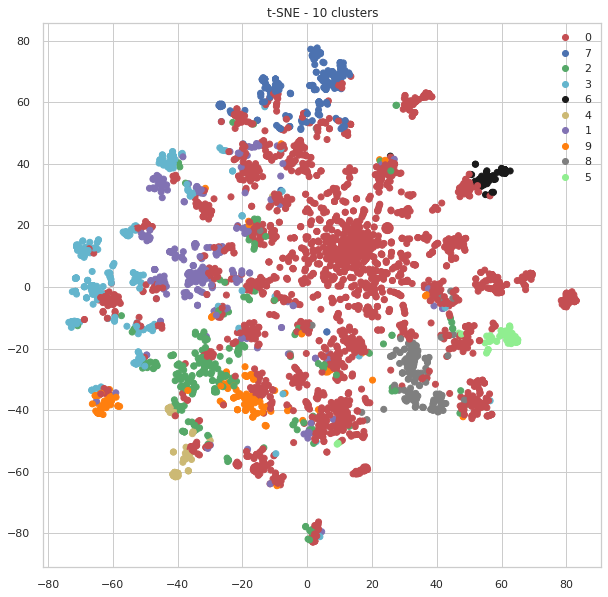

In [99]:
_, tsne_vectors, __, tsne_labels = train_test_split(tfidf_vectors, 
                                                    np.arange(0, tfidf_vectors.shape[0]), 
                                                    test_size=0.05,
                                                    random_state=42)
try:
    tsne = pickle.load(open('tsne.pickle', 'rb'))
except:
    tsne = TSNE(random_state=42).fit_transform(
        PCA(random_state=42, n_components=50).fit_transform(tsne_vectors.todense()))
    pickle.dump(tsne, open('tsne.pickle', 'wb'))

colours = ListedColormap(['r','b','g', 'c', 'k', 'y', 'm', 'tab:orange', 'tab:gray','lightgreen'])
plt.figure(figsize=(10,10))
scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=kmeans_labels[tsne_labels], cmap=colours)
_, legends_idx = np.unique(kmeans_labels[tsne_labels], return_index=True)
legend_labels = kmeans_labels[tsne_labels[np.sort(legends_idx)]]

plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels.tolist(), loc='best')

plt.title('t-SNE - 10 clusters')

plt.show()


Vemos que, apesar de vários cluster serem identificáveis, ainda sim o dado está bem disperso e temos muitas amostras da classe "0". Vários clusters, por exemplo, estão espalhados em vários agrupamentos. Isso pode ser explicado por alguns fatores. 

Primeiro, o treinamento do KMeans ficou com uma perfomance bastante negativa e o número de clusters escolhido (10) ainda possui uma inércia bem alta. 

Em segundo lugar, foram usados vetores TF-IDF. Apesar de representarem o dado de maneira coerente, eles não guardam um significado necessariamente espacial. Isso significa que duas descrições de compras bem similares que usem termos diferentes, irão possuir vetores diferentes que, matematicamente falando, podem estar bem distantes um do outro em um espaço n-dimensional.

Tendo isso em vista, vamos tentar outra abordagem então, utilizando modelagem de tópicos:

## Usando modelagem de tópicos

Modelagem de tópicos é uma tipo de modelo estatístico que permite a descoberta de tópicos, ou seja, "assuntos", que ocorrem em um conjunto de textos. Por meio dessa técnica, é possível agrupar os documentos em um número pré-determinado de tópicos e analisar os termos mais relevantes dentro de cada um desses tópicos.

Exitem alguns algoritmos capazes de realizar esse tipo de modelagem. No caso deste notebook, será usado o LDA (Latent Dirichlet Allocation).

O funcionamento desse algoritmo ocorre da seguinte forma:
Baseando-se em duas distribuições (chamadas de distribuições de Dirichlet), que são:
    * 1) Uma representando a distribuição de tópicos para cada documento, ou seja, o quanto cada tópico é representavivo para aquele documento;
    * 2) Outra representando a distribuição das palavras para cada tópico, ou seja, o quanto cada palavra do vocabulário é representativa para aquele tópico.

A partir da primeira distruição, que nos dá o quanto cada tópico é relevante para um determinado documento, é possível gerar uma lista de tópicos, que segue essa distribuição. 

A partir da segunda distribuição é gerado uma lista de palavras que segue uma distribuição representando o quanto cada palavra é relevante para cada tópico.

Agora de acordo com cada tópico da primeira lista, seleciona-se palavras levando em conta o quão provável é dessa palavra pertencer a esse tópico e ao final, se gera um novo documento como saída.

O objetivo do algoritmo, ou seja, o que ele busca aprender, é como gerar documentos de saída que sejam mais similares aos de entrada. Dizendo de outra forma, como ter uma saída que seja mais provável de ser semelhante os documentos cujos tópicos queremos representar.

Então, imaginando que no nosso caso tenhamos 3 tópicos relacionados às compras ("saúde", "educação", "transporte") e que entrada para o algoritmo seja um documento assim: "medicamentos cadeira placa". Supondo que o algoritmo dê a seguinte distribuição para o documento em relação aos tópicos:



|"saúde"| "educação" |"transporte"|
|-------|------------|------------|
|0.7|0.2|0.1|

E a seguinte para as palavras em relação aos tópicos:

**saúde**

|"medicamentos"| "cadeira" |"placa"|
|-------|------------|------------|
|0.8|0.1|0.1|

**educação**


|"medicamentos"| "cadeira" |"placa"|
|-------|------------|------------|
|0.1|0.7|0.2|

**transporte**

|"medicamentos"| "cadeira" |"placa"|
|-------|------------|------------|
|0.0|0.1|0.9|

Ao gerar a lista de tópicos seguindo a primeira distribuição, teríamos algo como:

* "saúde"
* "saúde"
* "educação"

E selecionando as palavras de acordo com os tópicos selecionados:

* "saúde" -> "medicamentos"
* "saúde" -> "medicamentos"
* "educação" -> "cadeira"

Nesse exemplo simples, o algoritmo entende que "medicamentos" é um termo muito importante para o tópico saúde, logo novos documentos que apresentem esse termo serão vistos como mais próximos desse tópicos também.

Agora, vamos aplicar essa ideia na prática:

In [100]:
tokens = [word_tokenize(doc) for doc in preprocessed_text.values]

In [101]:
tokens[:3]

[['merenda', 'escolar'],
 ['protocoladora', 'fragmentadora', 'papel'],
 ['materiais', 'limpeza', 'diversas']]

In [102]:
import gensim
from gensim import corpora, models

dictionary = corpora.Dictionary(tokens)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokens]

tfidf_gensim = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf_gensim[bow_corpus]

# lda_model_v1 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [103]:
# lda_model_v1.save('lda_model_v1')

In [104]:
lda_model_v1 = gensim.models.LdaMulticore.load('lda_model_v1')

In [105]:
lda_model_v1.show_topics()

[(0,
  '0.027*"material" + 0.025*"materiais" + 0.017*"limpeza" + 0.013*"equipamentos" + 0.012*"saude" + 0.011*"higiene" + 0.011*"expediente" + 0.010*"informatica" + 0.009*"eletrico" + 0.007*"manutencao"'),
 (1,
  '0.020*"agricultura" + 0.020*"familiar" + 0.013*"pecas" + 0.013*"alimenticios" + 0.013*"alimentacao" + 0.013*"escolar" + 0.007*"lubrificantes" + 0.006*"veiculos" + 0.006*"agricola" + 0.006*"rural"'),
 (2,
  '0.018*"alimenticios" + 0.016*"escolar" + 0.014*"merenda" + 0.013*"concreto" + 0.012*"tubos" + 0.011*"escolas" + 0.010*"ensino" + 0.008*"gas" + 0.007*"rede" + 0.007*"periodo"'),
 (3,
  '0.016*"veiculo" + 0.016*"pneus" + 0.010*"veiculos" + 0.010*"novos" + 0.008*"saude" + 0.008*"ar" + 0.008*"tipo" + 0.008*"km" + 0.007*"agua" + 0.007*"equipamentos"'),
 (4,
  '0.016*"medicamentos" + 0.008*"construcao" + 0.008*"fraldas" + 0.007*"aquisicoes" + 0.007*"materiais" + 0.006*"futuras" + 0.006*"distribuicao" + 0.006*"brita" + 0.006*"mg" + 0.006*"processo"')]

In [106]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_v1, corpus_tfidf, dictionary)
# pyLDAvis.save_html(vis, 'topic_modeling.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.173178  0.076646       1        1  23.638821
1     -0.235594  0.000341       2        1  20.242765
4      0.102017 -0.087224       3        1  19.543348
3     -0.007359 -0.159342       4        1  18.884539
2     -0.032241  0.169578       5        1  17.690528, topic_info=             Term         Freq        Total Category  logprob  loglift
69    agricultura   855.000000   855.000000  Default  30.0000  30.0000
115      familiar   824.000000   824.000000  Default  29.0000  29.0000
6         limpeza   842.000000   842.000000  Default  28.0000  28.0000
0         escolar  1156.000000  1156.000000  Default  27.0000  27.0000
184         pneus   651.000000   651.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
75       educacao   179.504212   631.425102   Topic5  -5.3166   0.4744
63       infantil   149.429870   335.351794   Topic5  -5.5000   0.9238
288   contratacao   156.687706   816.467799   Topic5  -5.4526   0.0814
1041   destinados   142.245808   398.048679   Topic5  -5.5493   0.7031
290       empresa   143.218705   705.680082   Topic5  -5.5424   0.1374

[356 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1870      5  0.960144       abastecer
952       1  0.024449        academia
952       4  0.965727        academia
7746      1  0.019725  acessibilidade
7746      4  0.966542  acessibilidade
...     ...       ...             ...
1336      5  0.008617          viaria
1058      2  0.042966            zero
1058      3  0.003906            zero
1058      4  0.949153            zero
1058      5  0.003906            zero

[781 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 4, 3])


## **Aviso**

Infelizmente, o GitHub não permite observar os gráficos gerados pelo pyLDAvis online. Para acessar o gráfico que deveria aparecer acima, acesse esse [link](https://htmlpreview.github.io/?https://github.com/joaorobson/machine_learning/blob/main/topic_modeling.html) ou realize o download e a execução do notebook como explicado no README.

Acima, podemos visualizar o resultado treinando o LDA com 5 tópicos. Já foi possível obter um bom resultado, principalmente tendo em vista os tópicos 2, 4 e 5. O primeiro tem muitos termos relacionadaos a alimentação. Já o segundo parece estar relacionado a veículos/transporte, pois há a presença de termos como "veiculo", "km", "placa" e "caminhao". O terceiro contém muitos termos entre os mais relevantes relacionados à educação, como "escolar", "merenda", "escolas" e "ensino". 

Os outros tópicos parecem ser mais genéricos. Os 2, por exemplo, possuem termos como "material" e "materiais" como mais importantes. Apesar disso, há certo sentido em alguns termos que aparecem juntos. O tópico número 3, por exemplo, apresenta 2 termos relacionados à construção civil ("brita" e "construcao"). Mas no mesmo tópico, há a presença de termos da área da saúde também ("medicamentos", "fralda", "geriatricas").

Tendo em vista o que foi falado acima, vamos adicionar mais algumas palavras nas *stopwords*, limpar um pouco mais o dado e treinar o LDA mais uma vez:

In [107]:
new_stop_words = ["material", "materiais", "s", "bens", "mg", "comum", "permanente", "termo", "constantes",
                  "periodo","especificacoes", "exclusivo", "suprir", "necessidades", "meses", "parceladas",
                  "referencia", "lei", "destinados", "objeto", "proposta", "eventual", "futura"]

preprocessed_text_v2 = preprocessed_text.apply(lambda x: " ".join(x for x in x.split() if x not in new_stop_words))    


In [108]:
tokens_v2 = [word_tokenize(doc) for doc in preprocessed_text_v2.values]



In [109]:
dictionary = corpora.Dictionary(tokens_v2)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokens_v2]

tfidf_gensim = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf_gensim[bow_corpus]

# lda_model_v2 = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=3, workers=2)

In [110]:
# lda_model.save('lda_model_v2')

In [111]:
lda_model_v2 = gensim.models.LdaMulticore.load('lda_model_v2')

In [112]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_v2, corpus_tfidf, dictionary)
# pyLDAvis.save_html(vis, 'topic_modeling_v2.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.054027  0.114475       1        1  26.600567
4     -0.204833 -0.171451       2        1  21.191317
0     -0.064181  0.122735       3        1  18.836311
3      0.213022 -0.157763       4        1  17.873765
2      0.001964  0.092003       5        1  15.498039, topic_info=             Term         Freq        Total Category  logprob  loglift
51   alimenticios  1483.000000  1483.000000  Default  30.0000  30.0000
6         limpeza   932.000000   932.000000  Default  29.0000  29.0000
29   medicamentos   985.000000   985.000000  Default  28.0000  28.0000
0         escolar  1248.000000  1248.000000  Default  27.0000  27.0000
123    expediente   864.000000   864.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
75          obras   109.525936   529.739321   Topic5  -5.6399   0.2882
51   alimenticios   134.164483  1483.288390   Topic5  -5.4370  -0.5385
0         escolar   101.464808  1248.267838   Topic5  -5.7164  -0.6453
400      presente    94.177600   465.052857   Topic5  -5.7909   0.2675
54        escolas    93.657484   729.163159   Topic5  -5.7964  -0.1878

[329 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
934       1  0.988937      academia
4717      4  0.983148        adesao
5282      1  0.975883      admitido
895       4  0.076037         adubo
895       5  0.912440         adubo
...     ...       ...           ...
3419      4  0.023645  veterinarios
3419      5  0.969454  veterinarios
2242      3  0.988100          vias
1039      1  0.995587          zero
1039      5  0.003874          zero

[571 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

## **Aviso**

Infelizmente, o GitHub não permite observar os gráficos gerados pelo pyLDAvis online. Para acessar o gráfico que deveria aparecer acima, acesse esse [link](https://htmlpreview.github.io/?https://github.com/joaorobson/machine_learning/blob/main/topic_modeling_v2.html) ou realize o download e a execução do notebook como explicado no README.

O resultado acima, apesar de não ser excelente e conter certa mistura entre diferentes setores, nos dá uma boa ideia do que se trata cada tópico. Dessa forma, vamos realizar uma filtragem manual e criar 5 classes/áreas tomando como base nesses 5 tópicos:
* Tópico 1 (Transporte): "veiculo", "pecas", "pneus", "frota", "km", "placa", "veiculos", "caminhao", "gasolina", "combustivel", "diesel", "lubrificantes", "ambulancia" ;
* Tópico 2 (Educação): "escolar", "escolares","escola","merenda", "infantil", "fundamental",  "educacao", "escolas", "alunos", "ensino";
* Tópico 3 (Construção): "construcao", "concreto", "tubos", "obras", "brita", "asfaltica";
* Tópico 4 (Saúde): "medicamentos", "saude", "fraldas", "hospitalar", "hospitalares", "geriatricas", "pacientes", "farmacia", "ambulatorial" 
* Tópico 5 (Limpeza): "limpeza", "higiene".

Baseando-se nesses termos, vamos designar uma das 5 classes para cada amostra que temos. No caso de haver não haver nenhum termo dessas classes na descrição pré-processada, será designada a classe "outros".


In [113]:
health = ["medicamentos", "saude", "fraldas", "hospitalar", "hospitalares", "geriatricas", "pacientes", "farmacia", "ambulatorial" ]
transportation = ["veiculo", "pecas", "pneus", "frota", "km", "placa", "veiculos", "caminhao", "gasolina", 
                  "combustivel", "diesel", "lubrificantes", "ambulancia"]
cleaning = ["limpeza", "higiene"]
education = ["escolar", "escolares","escola","merenda", "infantil", "fundamental",  "educacao", "escolas", "alunos", "ensino"]
construction = ["construcao", "concreto", "tubos", "obras", "brita", "asfaltica"]

In [114]:
classes = []
for doc in tokens_v2:
    class_ = []
    doc_vocab = set(doc)
    
    if doc_vocab.intersection(set(health)):
        class_.append("saude")
    if doc_vocab.intersection(set(transportation)):
        class_.append("transporte")    
    if doc_vocab.intersection(set(cleaning)):
        class_.append("limpeza")    
    if doc_vocab.intersection(set(education)):
        class_.append("educacao")    
    if doc_vocab.intersection(set(construction)):
        class_.append("construcao")   
    
    if len(class_) == 0:
        classes.append("outros")
    else:
        classes.append(class_)
classes = np.array(classes, dtype=object)     

Vamos ver se existem muitas amostras com mais de uma classe designada:

In [115]:
more_than_one_class_samples = [(ix,n) for ix, n in enumerate(classes) if len(n) > 1 and type(n) != str]
print("Amostras com mais de uma classe:", len(more_than_one_class_samples))

Amostras com mais de uma classe: 4357


Quase 5% das amostras estão com duas classes ou mais. Vamos verificar se é possível identificar a classe "mais correta" para alguns desses casos:

In [116]:
more_than_one_class_samples[:3]

[(9, ['saude', 'educacao', 'construcao']),
 (19, ['saude', 'limpeza']),
 (39, ['limpeza', 'educacao'])]

In [117]:
tokens_v2[9]

['cargas',
 'gas',
 'liquefeito',
 'petroleo',
 'p',
 'p',
 'solicitados',
 'mun',
 'educacao',
 'cultura',
 'desporto',
 'lazer',
 'mun',
 'saude',
 'assistencia',
 'social',
 'agricultura',
 'meio',
 'ambiente',
 'mun',
 'obras',
 'viacao',
 'habitacao',
 'servicos',
 'publicos',
 'administracao']

Vemos que ao olhar detalhadamente, se trata de aquisição de gás de cozinha para a secretaria de educação, para a de saúde, a de obras, entre outras. Como há a presença de termos que pertencem a mais de uma classe, nossa heurística falha nesses casos. 

Um algoritmo mais sofisticado, que levasse em conta a sequência das palavras ou o contexto (palavras ao redor de outra palavra) talvez tivesse resultados melhores. Para manter a simplicidade e tentando abarcar somente os casos onde há uma grande certeza da licitação pertence a um setos exclusivo, vamos considerar casos onde uma amostra possui mais de uma classe como "outros" também:

In [118]:
classes = []
for doc in tokens_v2:
    class_ = []
    doc_vocab = set(doc)
    
    if doc_vocab.intersection(set(health)):
        class_.append("saude")
    if doc_vocab.intersection(set(transportation)):
        class_.append("transporte")    
    if doc_vocab.intersection(set(cleaning)):
        class_.append("limpeza")    
    if doc_vocab.intersection(set(education)):
        class_.append("educacao")    
    if doc_vocab.intersection(set(construction)):
        class_.append("construcao")   
    
    if len(class_) > 1 or len(class_) == 0:
        classes.append("outros")
    else:
        classes.append(class_[0])
classes = np.array(classes, dtype=object)     

Agora vamos checar como está a distribuição das amostras entre cada classe:

In [119]:
classes_names, classes_counts = np.unique(classes, return_counts=True)

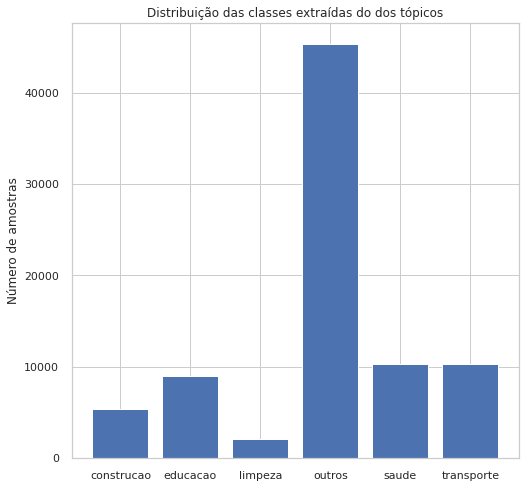

In [120]:
plt.figure(figsize=(8,8))
plt.bar(classes_names, classes_counts)
plt.title("Distribuição das classes extraídas do dos tópicos")
plt.ylabel("Número de amostras")
plt.show()

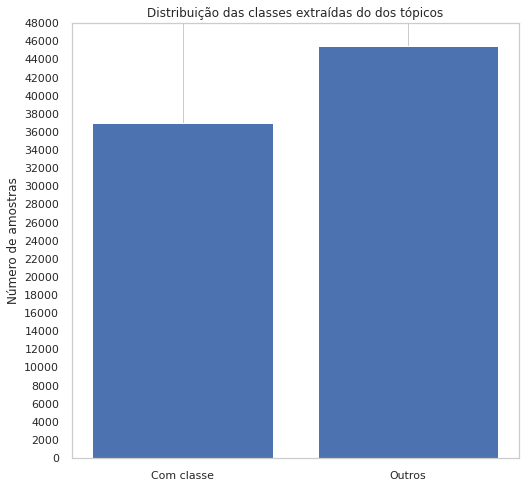

In [121]:
plt.figure(figsize=(8,8))
plt.bar(["Com classe", "Outros"], [len(classes[classes != "outros"]), len(classes[classes == "outros"])])
plt.title("Distribuição das classes extraídas do dos tópicos")
plt.ylabel("Número de amostras")
plt.yticks(np.arange(0, 50000, 2000))
plt.grid(axis='y')
plt.show()

Vemos que ainda existem muitas amostras sem uma classe designada e há cerca de 10000 amostras com classe a menos do que "Outros". Vamos dar uma olhada nos termos mais frequentes nessas amostras rotuladas como "outros":

In [122]:
others_words_freq = get_words_frequency(preprocessed_text_v2.loc[np.where(classes == "outros")])

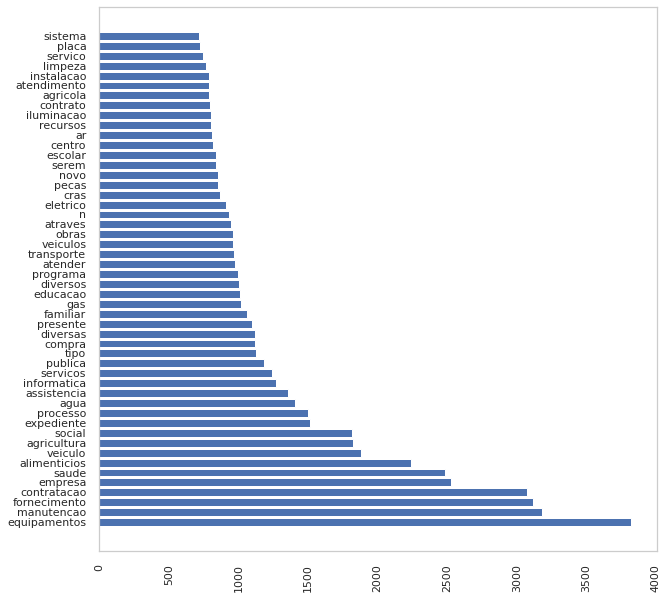

In [123]:
plt.figure(figsize=(10,10))
plt.barh(list(others_words_freq.keys())[:50], list(others_words_freq.values())[:50])
plt.xticks(rotation=90)
plt.grid()
plt.show()

Como mostrado acima, percebe-se que os 50 termos mais frequentes para as descrições enquadradas como "outros" são bem genéricos, ou seja, com a abordagem que estamos utilizando, é difícil avançar para um resultado melhor. Uma opção a ser testada é aumentar o número de tópicos possíveis para checar se há uma separação melhor dos termos. Vamos testar essa hipótese aumentando o número de tópicos em 2. Antes de fazer isso, vamos retirar mais palavras descobertas pelo gráfico acima ("tipo", "processo", etc.) que não dão pistas tão claras do que se trata a licitação:

## Teste com 7 tópicos

In [124]:
new_stop_words = ["sul", "n", "tipo", "processo", "diversas", "centro", "ser"]

preprocessed_text_v3 = preprocessed_text_v2.apply(lambda x: " ".join(x for x in x.split() if x not in new_stop_words))    


In [125]:
tokens_v3 = [word_tokenize(doc) for doc in preprocessed_text_v3.values]


In [126]:
dictionary = corpora.Dictionary(tokens_v3)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokens_v3]

tfidf_gensim = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf_gensim[bow_corpus]

# lda_model_v2_7_topics = gensim.models.LdaMulticore(corpus_tfidf, num_topics=7, id2word=dictionary, passes=3, workers=2)

In [127]:
# lda_model_v2_7_topics.save('lda_model_v2_7_topics')

In [128]:
lda_model_v2_7_topics = gensim.models.LdaMulticore.load('lda_model_v2_7_topics')

In [129]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_v2_7_topics, corpus_tfidf, dictionary)
# pyLDAvis.save_html(vis, 'topic_modeling_v2_7_topics.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.013622  0.259967       1        1  17.263188
2     -0.245279 -0.048578       2        1  16.388193
5      0.049299 -0.038341       3        1  14.039153
3      0.165571 -0.069373       4        1  13.774935
4     -0.036360 -0.155205       5        1  13.079116
0     -0.083105  0.067216       6        1  12.951965
1      0.136251 -0.015686       7        1  12.503450, topic_info=              Term         Freq        Total Category  logprob  loglift
106       familiar   833.000000   833.000000  Default  30.0000  30.0000
27    medicamentos  1057.000000  1057.000000  Default  29.0000  29.0000
5          limpeza   919.000000   919.000000  Default  28.0000  28.0000
172          pneus   656.000000   656.000000  Default  27.0000  27.0000
61     agricultura   847.000000   847.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
637     presencial    89.257787   332.321031   Topic7  -5.6210   0.7646
73           obras    95.190796   539.150510   Topic7  -5.5566   0.3451
78        servicos    84.961042   461.457496   Topic7  -5.6703   0.3870
1392       demanda    82.892918   331.329501   Topic7  -5.6950   0.6936
212      eletricos    80.051397   318.404908   Topic7  -5.7298   0.6985

[462 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
928       6  0.992997         academia
4710      1  0.979817           adesao
5275      1  0.020231         admitido
5275      6  0.971066         admitido
2004      7  0.978204            afins
...     ...       ...              ...
2145      1  0.974683  vulnerabilidade
1032      1  0.890197             zero
1032      2  0.007449             zero
1032      6  0.033522             zero
1032      7  0.067044             zero

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 6, 4, 5, 1, 2])

## **Aviso**

Infelizmente, o GitHub não permite observar os gráficos gerados pelo pyLDAvis online. Para acessar o gráfico que deveria aparecer acima, acesse esse [link](https://htmlpreview.github.io/?https://github.com/joaorobson/machine_learning/blob/main/topic_modeling_v2_7_topics.html) ou realize o download e a execução do notebook como explicado no README.

Os dois novos tópicos criados ajudam a criar duas novas classe: "Alimentação/Agricultura" e "Cozinha", representados pelos tópicos 2 e 7 respectivamente. Também é perceptível que com mais 2 tópicos, alguns dos outros 5 definidos previamente ficaram com termos menos específicos e se misturam ou acabam aparencendo mais de uma vez. Apesar disso atrapalhar um pouco nesta análise, vamos nos atentar a novos termos que podemos incluir nos tópicos antigos, marcando os tópicos e termos novos em negrito:

* Tópico 1 e 3 (Transporte): "veiculo", "pecas", "pneus", "frota", "km", "placa", "veiculos", "caminhao", "gasolina", "combustivel", "diesel", "lubrificantes", "ambulancia", **"van"**, **"onibus"**, **"transporte"**, **"placas"**;
* **Tópico 2 (Alimentação/Agricultura): "alimenticios", "agricultura", "alimentacao", "agricolas", "cestas";**
* Tópico 4.1 (Limpeza): "limpeza", "higiene", **"higienizacao"**;
* Tópico 4.2 (Construção): "construcao", "concreto", "tubos", "obras", "brita", "asfaltica";
* Tópico 5 (Educação): "escolar", "escolares","escola","merenda", "infantil", "fundamental",  "educacao", "escolas", "alunos", "ensino", **"livros"**, **"cultura"**;
* Tópico 6 (Saúde): "medicamentos", "saude", "fraldas", "hospitalar", "hospitalares", "geriatricas", "pacientes", "farmacia", "ambulatorial", **"odontologicos"**, **"ubs"**, **"ambulatoriais"**; 
* **Tópico 7 (Cozinha): "cozinha", "copa", "gas", "glp"**.

Com isso, podemos repetir o fluxo realizado anteriormente:

In [130]:
health = ["medicamentos", "saude", "fraldas", "hospitalar", "hospitalares", "geriatricas", "pacientes", 
          "farmacia", "ambulatorial", "odontologicos", "ubs", "ambulatoriais" ]

transportation = ["veiculo", "pecas", "pneus", "frota", "km", "placa", "veiculos", "caminhao", "gasolina",
                  "combustivel", "diesel", "lubrificantes", "ambulancia", "van", "onibus", "transporte", "placas"]

cleaning = ["limpeza", "higiene", "higienizacao"]

education = [ "escolar", "escolares","escola","merenda", "infantil", "fundamental", "educacao", "escolas", "alunos", 
             "ensino", "livros", "cultura"]

construction = ["construcao", "concreto", "tubos", "obras", "brita", "asfaltica"]

feeding_agriculture = ["alimenticios", "agricultura", "alimentacao", "agricolas", "cestas"]

kitchen = ["cozinha", "copa", "gas", "glp"]

In [131]:
classes = []
for doc in tokens_v3:
    class_ = []
    doc_vocab = set(doc)
    
    if doc_vocab.intersection(set(health)):
        class_.append("saude")
    if doc_vocab.intersection(set(transportation)):
        class_.append("transporte")    
    if doc_vocab.intersection(set(cleaning)):
        class_.append("limpeza")    
    if doc_vocab.intersection(set(education)):
        class_.append("educacao")    
    if doc_vocab.intersection(set(construction)):
        class_.append("construcao")   
    if doc_vocab.intersection(set(feeding_agriculture)):
        class_.append("alimentacao/agricultura")  
    if doc_vocab.intersection(set(kitchen)):
        class_.append("cozinha")
        
    if len(class_) > 1 or len(class_) == 0:
        classes.append("outros")
    else:
        classes.append(class_[0])
classes = np.array(classes)     

In [132]:
classes_names, classes_counts = np.unique(classes, return_counts=True)

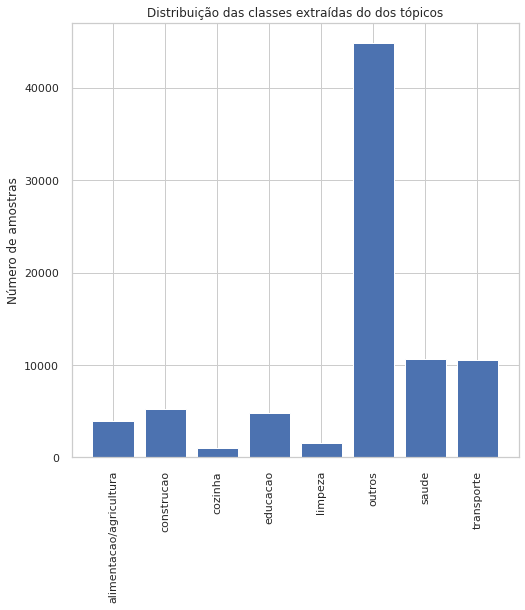

In [133]:
plt.figure(figsize=(8,8))
plt.bar(classes_names, classes_counts)
plt.title("Distribuição das classes extraídas do dos tópicos")
plt.ylabel("Número de amostras")
plt.xticks(rotation=90)
plt.show()

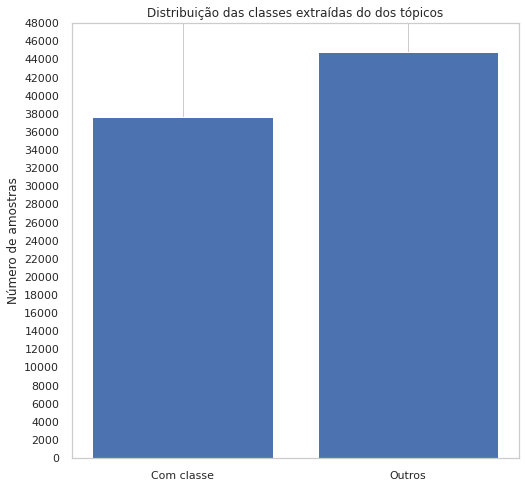

In [134]:
plt.figure(figsize=(8,8))
plt.bar(["Com classe", "Outros"], [len(classes[classes != "outros"]), len(classes[classes == "outros"])])
plt.title("Distribuição das classes extraídas do dos tópicos")
plt.ylabel("Número de amostras")
plt.yticks(np.arange(0, 50000, 2000))
plt.grid(axis='y')
plt.show()

Com a inclusão de novas classes, houve um leve aumento de amostras com classe (cerca de 1000). Vamos checar novamente as 50 palavras mais frequentes para as amostras em "Outros":

In [135]:
others_words_freq = get_words_frequency(preprocessed_text_v3.loc[np.where(classes == "outros")])

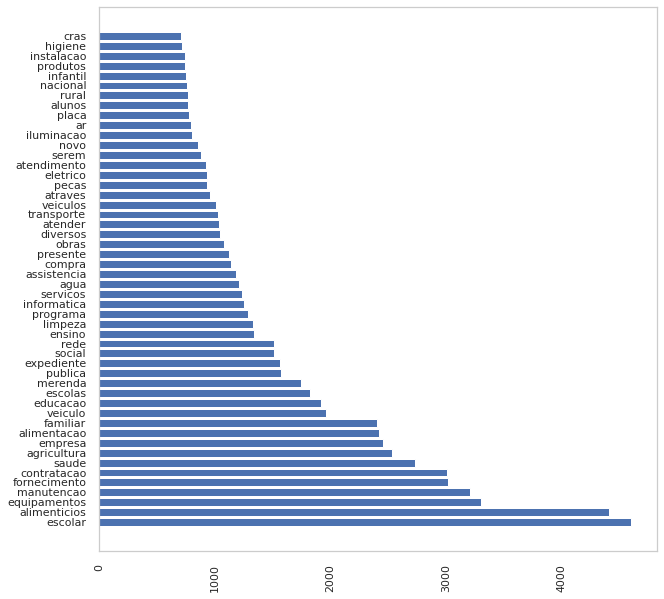

In [136]:
plt.figure(figsize=(10,10))
plt.barh(list(others_words_freq.keys())[:50], list(others_words_freq.values())[:50])
plt.xticks(rotation=90)
plt.grid()
plt.show()

Como anteriormente, a maior parte esmagadora das palavras não é específica o suficente para determinar de que setor se trata a compra. Porém, há uma excecção: há uma palavra muito frequente e específica que é "informatica". Vamos criar uma nova classe ("Informática") que inclui amostras com essa palavra:

In [137]:
info_tech = ["informatica"]

classes = []
for doc in tokens_v3:
    class_ = []
    doc_vocab = set(doc)
    
    if doc_vocab.intersection(set(health)):
        class_.append("saude")
    if doc_vocab.intersection(set(transportation)):
        class_.append("transporte")    
    if doc_vocab.intersection(set(cleaning)):
        class_.append("limpeza")    
    if doc_vocab.intersection(set(education)):
        class_.append("educacao")    
    if doc_vocab.intersection(set(construction)):
        class_.append("construcao")   
    if doc_vocab.intersection(set(feeding_agriculture)):
        class_.append("alimentacao/agricultura")  
    if doc_vocab.intersection(set(kitchen)):
        class_.append("cozinha")
    if doc_vocab.intersection(set(info_tech)):
        class_.append("informatica")  

    if len(class_) > 1 or len(class_) == 0:
        classes.append("outros")
    else:
        classes.append(class_[0])
classes = np.array(classes)     

In [138]:
classes_names, classes_counts = np.unique(classes, return_counts=True)

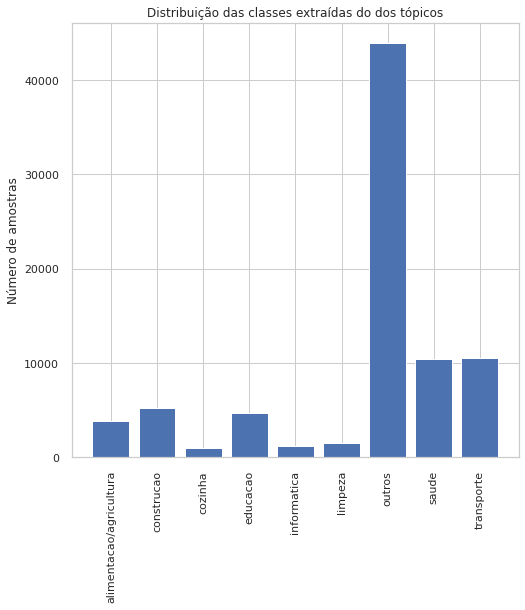

In [139]:
plt.figure(figsize=(8,8))
plt.bar(classes_names, classes_counts)
plt.title("Distribuição das classes extraídas do dos tópicos")
plt.ylabel("Número de amostras")
plt.xticks(rotation=90)
plt.show()

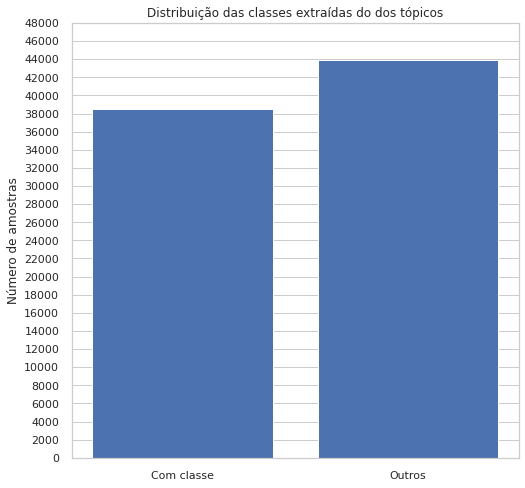

In [140]:
plt.figure(figsize=(8,8))
plt.bar(["Com classe", "Outros"], [len(classes[classes != "outros"]), len(classes[classes == "outros"])])
plt.title("Distribuição das classes extraídas do dos tópicos")
plt.ylabel("Número de amostras")
plt.yticks(np.arange(0, 50000, 2000))
plt.grid(axis='x')
plt.show()

Conseguimos mais algumas centenas de amostras com classe! Agora, é possível tentar encontrar dois tipos de padrão:
* Há algum tipo de tendência por área entre as classes de tamanho de municípo?
* É possível identificar se algum dos setores acima tem gastos muito maiores que outros?

Além disso, é importante responder a duas perguntas que foram feitas lá atrás:
* O que foi licitado pelo município de Viamão em 2016 em sua compra mais cara?
* O que foi licitado pelo município de Tapera em 2019 em sua compra mais cara?

Vamos iniciar pelas duas últimas perguntas, mas antes, vamos criar uma coluna no dataframe *bids_with_items* para armazenar a última versão do dado pré-processado:

In [141]:
bids_with_items["DS_OBJETO_PP"] = preprocessed_text_v3

## Item mais caro licitado por Viamão em 2016

In [142]:
items_viamao_2016 = bids_with_items[(bids_with_items["NOME DO MUNICÍPIO"] == "VIAMÃO") & 
                                    (bids_with_items["ANO_LICITACAO"] == 2016)]

In [143]:
items_viamao_2016[items_viamao_2016["VL_HOMOLOGADO"] == 
                  items_viamao_2016["VL_HOMOLOGADO"].max()]["DS_OBJETO"].values

array(['AQAUISIÇÃO DE GÊNEROS ALIMENTÍCIOS PARA ALIMENTAÇÃO ESCOLAR'],
      dtype=object)

Vemos que a compra se trata de uma aquisição de alimentos para escolas. Vamos ver qual classe foi atribuída para este gasto:


In [144]:
classes[items_viamao_2016[items_viamao_2016["VL_HOMOLOGADO"] == 
                  items_viamao_2016["VL_HOMOLOGADO"].max()]["DS_OBJETO"].index[0]]

'outros'

Por conta da simplificação da heurística de escolha das classes, a classe do maior valor homologado para 2016 foi registrada como "outros" por pertencer tanto à "alimentação" quanto à "educação". Ao analisar os gastos por classe, vamos checar a proporção dos gastos para essas duas classes em relação à compra acima.

## Item mais caro licitado por Tapera em 2019

In [145]:
items_tapera_2019 = bids_with_items[(bids_with_items["NOME DO MUNICÍPIO"] == "TAPERA") & 
                                    (bids_with_items["ANO_LICITACAO"] == 2019)]

In [146]:
items_tapera_2019[items_tapera_2019["VL_HOMOLOGADO"] == 
                  items_tapera_2019["VL_HOMOLOGADO"].max()]["DS_OBJETO"].values

array(['REFERENTE AQUISIÇÃODE UNIFORMES PARA AS SECRETARIAS MUNICIPAIS DO MUNICIPIO DE TAPERA.'],
      dtype=object)

In [147]:
classes[items_tapera_2019[items_tapera_2019["VL_HOMOLOGADO"] == 
                  items_tapera_2019["VL_HOMOLOGADO"].max()]["DS_OBJETO"].index[0]]

'outros'

Para o caso de Tapera, a atribuição de uma classe não ocorreu por não haver algum termo que determine de maneira específica do que se trata a compra. Vamos avaliar o valor dessa compra em relação a outras que tratem de aquisição de uniformes e vestimentas na etapa de análise entre setores dos gastos e valores homologados.

## Gasto total por setor

In [148]:
bids_with_items["SETOR"] = classes

In [149]:
bids_with_items.head()

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,VL_LICITACAO,VL_HOMOLOGADO,NR_PROCESSO,NOME DO MUNICÍPIO,DS_OBJETO,DS_OBJETO_PP,SETOR
0,84100,PM DE ESPERANÇA DO SUL,4.0,2016,CNV,11216.5,NaN,003,ESPERANÇA DO SUL,Aquisição de merenda escolar,merenda escolar,educacao
1,82701,CM DE XANGRI-LÁ,1.0,2016,PRP,NaN,NaN,01,XANGRI-LÁ,AQUISIÇÃO DE PROTOCOLADORA E FRAGMENTADORA DE ...,protocoladora fragmentadora papel,outros
2,84100,PM DE ESPERANÇA DO SUL,6.0,2016,CNV,59810.6,NaN,005,ESPERANÇA DO SUL,Aquisição de materiais de limpeza para as dive...,limpeza,limpeza
3,53100,PM DE NOVA PALMA,3.0,2016,PRP,251.7,NaN,07,NOVA PALMA,Aquisição de tubos de concreto,tubos concreto,construcao
4,86800,PM DE BOA VISTA DO SUL,3.0,2016,PRP,31384.9,NaN,004,BOA VISTA DO SUL,Aquisição de tubos de concreto,tubos concreto,construcao


In [150]:
bids_with_items_and_city = pd.merge(bids_with_items[["NOME DO MUNICÍPIO", "VL_HOMOLOGADO", "ANO_LICITACAO", "SETOR", "DS_OBJETO_PP"]], 
                                    cities_rs[["NOME DO MUNICÍPIO", "CLASSE"]], on="NOME DO MUNICÍPIO")
bids_with_items_and_city

,NOME DO MUNICÍPIO,VL_HOMOLOGADO,ANO_LICITACAO,SETOR,DS_OBJETO_PP,CLASSE
0,ESPERANÇA DO SUL,NaN,2016,educacao,merenda escolar,Menos de 5.000 hab.
1,ESPERANÇA DO SUL,NaN,2016,limpeza,limpeza,Menos de 5.000 hab.
2,ESPERANÇA DO SUL,NaN,2016,transporte,escavadeira hidraulica caminhao truque cacamba...,Menos de 5.000 hab.
3,ESPERANÇA DO SUL,NaN,2016,transporte,pneus novos camaras,Menos de 5.000 hab.
4,ESPERANÇA DO SUL,NaN,2016,outros,equipamento bomba agua submersa,Menos de 5.000 hab.
...,...,...,...,...,...,...
76199,AMARAL FERRADOR,30616.54,2019,limpeza,materias expediente produtos limpeza,Entre 5.0001 e 10.000 hab.
76200,AMARAL FERRADOR,32839.00,2019,transporte,pecas maquinas pesadas,Entre 5.0001 e 10.000 hab.
76201,AMARAL FERRADOR,85500.00,2019,transporte,veiculo ambulancia,Entre 5.0001 e 10.000 hab.
76202,AMARAL FERRADOR,0.00,2019,alimentacao/agricultura,implementos agricolas tratores,Entre 5.0001 e 10.000 hab.


In [151]:
spending_per_sector = bids_with_items_and_city.groupby(["SETOR"]).sum().reset_index()
spending_per_sector

,SETOR,VL_HOMOLOGADO,ANO_LICITACAO
0,alimentacao/agricultura,3.047812e+08,7719707
1,construcao,8.466640e+08,10391171
2,cozinha,4.298398e+07,1949107
3,educacao,3.228325e+08,9309642
4,informatica,8.899258e+07,2316133
5,limpeza,1.283205e+08,2913486
6,outros,8.278030e+09,79172064
7,saude,1.284314e+09,19554382
8,transporte,9.206769e+08,20427159


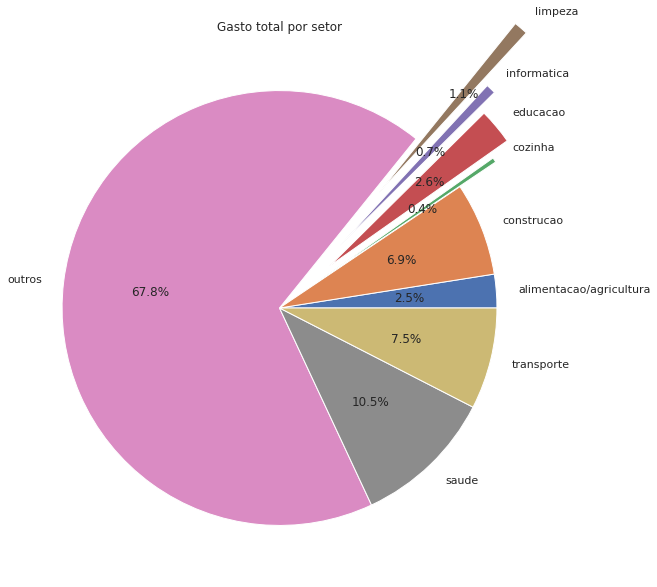

In [152]:
plt.figure(figsize=(10,10))
plt.pie( spending_per_sector["VL_HOMOLOGADO"],
       labels=spending_per_sector["SETOR"],
       autopct='%1.1f%%',
       explode=[0,0,0.2,0.3,0.4,0.7,0,0,0])
plt.title("Gasto total por setor")
plt.show()

Fica claro pelo gráfico acima que a classe "outros" concentra uma fatia muito grande dos gastos. Vamos remover os dados dessa classe e e checar a proporção considerando somente as classes realmente encontradas:

In [153]:
spending_per_sector_without_others = spending_per_sector[spending_per_sector["SETOR"] != "outros"]

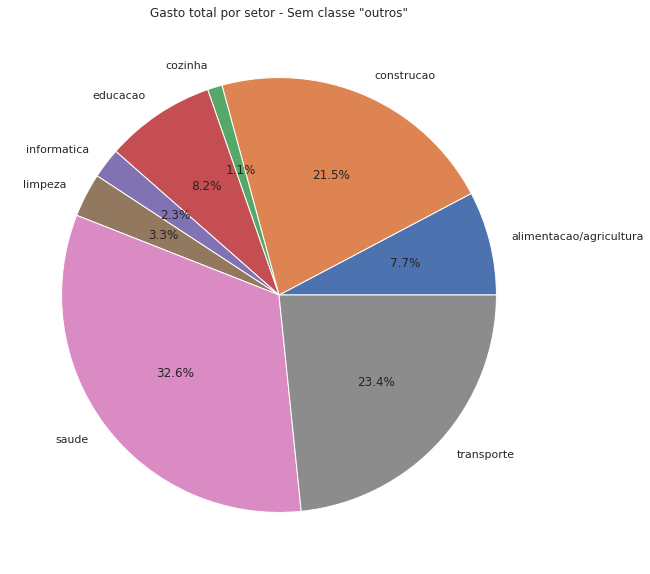

In [154]:
plt.figure(figsize=(10,10))
plt.pie(spending_per_sector_without_others["VL_HOMOLOGADO"],
       labels=spending_per_sector_without_others["SETOR"],
       autopct='%1.1f%%',
       )
plt.title('Gasto total por setor - Sem classe "outros"')
plt.show()

Sem a classe outros, é possível ver que os gastos com saúde, transporte e construção representam 77.5% do gasto total para as amostras que tiveram uma classe atribuída. Agora vamos checar o gasto para cada uma dessas classes dentro de cada faixa populacional:

## Relação entre setores e tamanho dos municípios

Vamos avaliar se há alguma tendência em relação aos setores estabelecidos anteriormente e o tamanho dos municípios

In [155]:
spending_per_sector_per_city_class = bids_with_items_and_city.groupby(["CLASSE", "SETOR"]).sum().reset_index()
spending_per_sector_per_city_class

,CLASSE,SETOR,VL_HOMOLOGADO,ANO_LICITACAO
0,Entre 10.001 e 20.000 hab.,alimentacao/agricultura,1.408677e+07,827266
1,Entre 10.001 e 20.000 hab.,construcao,7.353695e+07,1315518
2,Entre 10.001 e 20.000 hab.,cozinha,1.943924e+06,270378
3,Entre 10.001 e 20.000 hab.,educacao,1.297722e+07,1097535
4,Entre 10.001 e 20.000 hab.,informatica,7.272367e+06,276382
...,...,...,...,...
58,Menos de 5.000 hab.,informatica,6.958650e+06,562894
59,Menos de 5.000 hab.,limpeza,5.560113e+06,742497
60,Menos de 5.000 hab.,outros,2.293579e+08,21360934
61,Menos de 5.000 hab.,saude,8.856990e+07,5195268


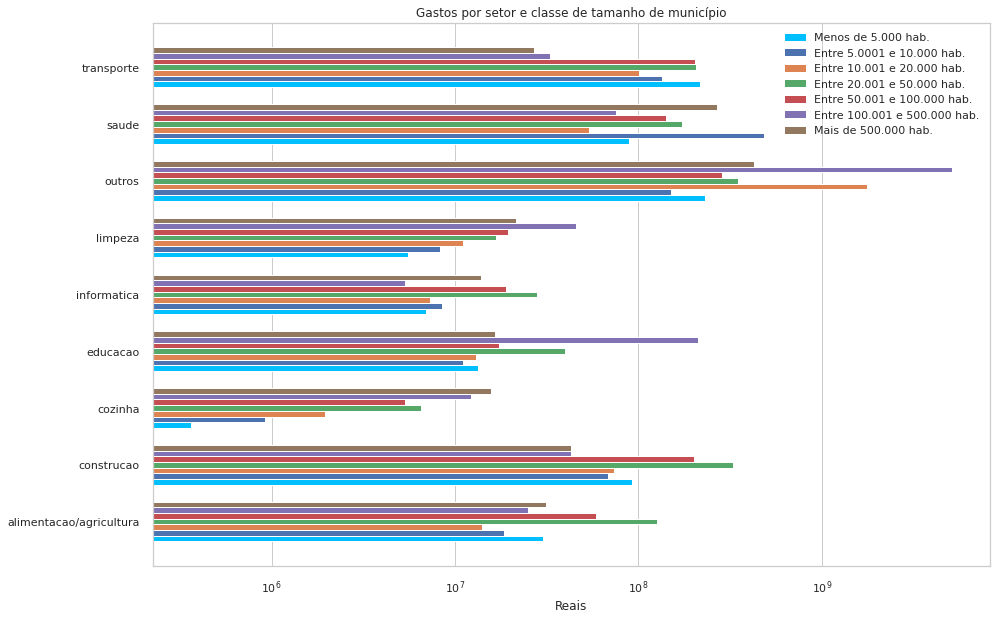

In [156]:
labels = spending_per_sector_per_city_class["SETOR"].unique()
city_classes = {"Menos de 5.000 hab.": [],
                "Entre 5.0001 e 10.000 hab.": [],
                "Entre 10.001 e 20.000 hab.": [],
                "Entre 20.001 e 50.000 hab.": [],
                "Entre 50.001 e 100.000 hab.": [],
                "Entre 100.001 e 500.000 hab.": [],
                "Mais de 500.000 hab.": []}

x = np.arange(0, 20*len(labels), 20) 
width = 2
fig, ax = plt.subplots(figsize=(15,10))

for ix, city_class in enumerate(city_classes):
    for sector in labels:
        city_classes[city_class].append(
            spending_per_sector_per_city_class[(spending_per_sector_per_city_class["CLASSE"] == city_class) & 
                                (spending_per_sector_per_city_class["SETOR"] == sector)
                               ]["VL_HOMOLOGADO"].values[0]
        )
    if ix == 0:
        ax.barh(x, city_classes[city_class], width, label=city_class, color='deepskyblue')
    else:
        ax.barh(x, city_classes[city_class], width, label=city_class)

    x += 2

ax.set_title("Gastos por setor e classe de tamanho de município")
ax.set_xlabel('Reais')
ax.set_yticks(x - 8)
ax.set_yticklabels(labels)
ax.legend()
ax.grid(axis='y')
ax.set_xscale('log')

plt.show()

Vemos pelo gráfico acima que para todos os tamanhos de município, os gastos na classe "outros" ultrapassa a casa das centenas de milhares de reais, sendo os municípios com população entre 100.001 e 500.000 habitantes os maiores gastadores, o que é reflexo do ponto fora da curva originado do município de Viamão.

Outro ponto importante a se destacar é que os segundo maior gastos em "outros" se concentra nos municípios com população entre 10.001 e 20.000 habitantes, na casa dos bilhões de reais. Como mostrado anteriormente também, esse valor alto é causado por uma compra do município de Tapera.

Em relação as outras classes, pode-se destacar:
* O gasto com educação para os municípios com população entre 100.001 e 500.000 habitantes;
* Gastos com construção para os municípios que tem população indo de 20.001 a 50 mil e 50.001 a 100 mil pessoas;
* Os gastos com saúde, que apresenta altos valores para praticamente todas as faixas de tamanho de município;

Agora vamos checar os gastos que incluem "uniformes", para comparação com a maior compra do município de Tapera:

## Compras de "uniformes"

In [157]:
spendings_with_uniforms = bids_with_items[bids_with_items["DS_OBJETO_PP"].str.contains("uniforme")]
spendings_with_uniforms

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,VL_LICITACAO,VL_HOMOLOGADO,NR_PROCESSO,NOME DO MUNICÍPIO,DS_OBJETO,DS_OBJETO_PP,SETOR
90,74000,PM DE BARRA FUNDA,3.0,2016,PRP,18857.50,NaN,03,BARRA FUNDA,Aquisição de uniformes escolares para as crian...,uniformes escolares criancas educacao infantil...,educacao
170,84100,PM DE ESPERANÇA DO SUL,35.0,2016,PRP,55362.00,NaN,008,ESPERANÇA DO SUL,Aquisição de uniformes escolares e uniformes p...,uniformes escolares uniformes servidores sec o...,outros
378,45200,PM DE CHAPADA,7.0,2016,CNV,76993.00,70750.00,025,CHAPADA,Contratação de empresa para a confecção de Uni...,contratacao empresa confeccao uniformes escola...,educacao
414,87056,EMPRESA PÚBLICA DE TRANSPORTE E CIRCULAÇÃO S/A.,8.0,2016,PRE,126016.77,93429.81,008.000216.16.0,None,AQUISIÇÃO DE UNIFORMES.,uniformes,outros
448,88261,FUND. DE SAÚDE PÚBLICA DE NOVO HAMBURGO,15.0,2016,PRE,159639.77,99990.00,90563,NOVO HAMBURGO,Aquisição de Uniformes para o SAMU da FSNH,uniformes samu fsnh,outros
...,...,...,...,...,...,...,...,...,...,...,...,...
82041,43500,PM DE CAMAQUÃ,8.0,2019,PRD,17596.00,0.00,171,CAMAQUÃ,Aquisição de uniformes personalizados para a SAMU,uniformes personalizados samu,outros
82060,54900,PM DE PORTO ALEGRE,85.0,2019,PRE,238144.54,283698.00,1900000447717,PORTO ALEGRE,"AQUISIÇÃO DE UNIFORMES, CAMA, MESA E BANHO",uniformes cama mesa banho,outros
82079,59100,PM DE SÃO MARTINHO,29.0,2019,PRD,5630.50,0.00,56,SÃO MARTINHO,AQUISIÇÃO DE UNIFORMES PARA OS SERVIDORES DO P...,uniformes servidores parque obras viacao servi...,construcao
82177,43000,PM DE CACHOEIRA DO SUL,24.0,2019,PRE,22976.00,21025.12,5255,CACHOEIRA DO SUL,"AQUISIÇÃO DE UNIFORMES, COTURNOS E APITOS.",uniformes coturnos apitos,outros


In [158]:
spendings_with_uniforms_per_sector = spendings_with_uniforms.groupby("SETOR").sum().reset_index()

In [159]:
spendings_with_uniforms_per_sector

,SETOR,CD_ORGAO,NR_LICITACAO,ANO_LICITACAO,VL_LICITACAO,VL_HOMOLOGADO
0,alimentacao/agricultura,177600,55.0,6051,5.685489e+04,3.124432e+04
1,construcao,1658100,3834.0,62548,1.223076e+06,1.873625e+05
2,cozinha,56900,14.0,2017,2.561602e+04,0.000000e+00
3,educacao,13723158,108435.0,431839,1.959615e+08,5.618430e+07
4,limpeza,224922,207.0,6050,9.293197e+04,2.396700e+04
5,outros,29114757,930754.0,984633,6.641949e+07,1.596658e+09
6,saude,4071509,109164.0,141246,2.241660e+06,5.007984e+05
7,transporte,334802,295.0,12103,2.056944e+05,1.982000e+04


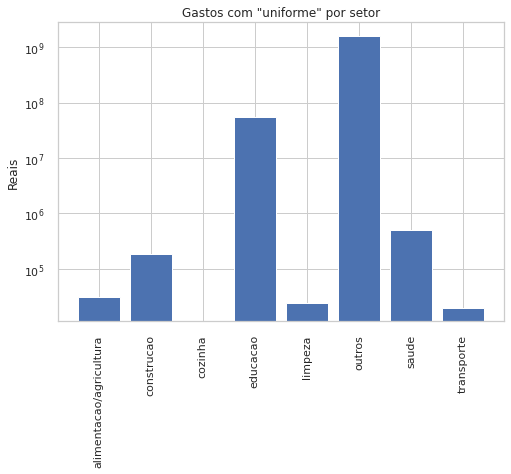

In [160]:
plt.bar(spendings_with_uniforms_per_sector["SETOR"], spendings_with_uniforms_per_sector["VL_HOMOLOGADO"])
plt.title('Gastos com "uniforme" por setor')
plt.yscale('log')
plt.ylabel("Reais")
plt.xticks(rotation=90)
plt.show()

Novamente, "outros" gastos concentram a maior fatia entre os setores, seguido por educação, que apesar de ter gastos altos, não passa da casa das dezenas de milhares de reais, um valor bem inferior à licitação de 1.5 bilhão de Tapera, que sozinha, representa quase que a totalidade de gastos com "uniforme" dentro da classe "outros".



Como todas as análise acima mostraram, a concentração de gastos em "outros" é bastante forte, apesar do uso de modelagem de tópicos já ter auxiliado bastante na visualização de alguns setores responsáveis pelas compras. Como falado anteriormente, o TF-IDF é uma técnica que funciona bem, apesar de sua simplicidade, porém não se preocupa muito com o significado de cada descrição em si, apenas com a frequência dos termos.

Felizmente, existem outras formas de transformar textos em entidades matemáticas que capturam o significado do que está escrito, ou seja, textos com escrita diferente mas com semântica parecida ficam mais próximos espacialmente. 

Uma forma de capturar essa semântica é utilizando entidades conhecidas como *neural network embeddings*.

*Embeddings* são representações aprendidas por redes neurais que permitem transformar variáveis discretas ou categóricas, como um texto, em um vetor de valores reais contínuos, preservando a similaridade semântica original dos textos.

Um dos algoritmos de *embedding* mais utilizado e conhecido é o *word2vec*. Basicamente, ele se trata de uma [rede neural](https://pt.wikipedia.org/wiki/Rede_neural_artificial), que é um modelo de aprendizado de máquina baseado na conexão neural dos nossos cérebros. 

O objetivo do *word2vec* é aprender representações vetoriais para as palavras de um texto e para isso ele funciona, de maneira simplificada, utilizando de entrada pares de palavras originados de uma grande quantidade de texto corrente. Se um par se tratar de palavras vizinhas, o modelo deve dar como saída "1", que representa a probabilidade das palavras serem vizinhas. Caso contrário, a saída deve ser 0. Por meio de várias interações, o modelo consegue aprender a melhore representação vetorial para as palavras de forma que palavras vizinhas tenham vetores similares espacialmente falando e palavras díspares vetores diferentes.

No problema aqui apresentado, podemos usar um *word2ved* já treinado previamente com a língua portuguesa e tentar formar clusters com a representação vetorial do texto que teve classes designadas utilizando modelagem de tópicos.

Se nossa metodologia que assinalou as classes estiver correta, os clusters, na teoria, estarão próximos espacialmente e poderemos avaliar, após isso, onde se localizam as descrições marcadas como "outros". 

Vamos testar isso:

## Usando word2vec

Iremos utilizar um modelo treinado usando a arquitetura skip-gram com vetores de 50 dimensões que foi disponibilizado pelo Núcleo Interinstitucional de Linguística Computacional da USP [aqui](http://www.nilc.icmc.usp.br/embeddings).

In [161]:
w2v = KeyedVectors.load_word2vec_format('skip_s50.txt')


Agora, vamos vetorizar nossos textos. Como dito anteriormente, o *word2vec* funciona transformando palavras em vetores. Porém, cada texto nosso tem 1 ou mais palavras. Por conta disso, a média dos vetores das palavras de cada amostra será calculado para termos um vetor por amostra:

In [162]:
# Retirado de https://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
# É uma classe que permite calcular a média de vetores w2v
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec, dim=50):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X):
        i = 0
        for words in X:
            print(i + 1, 'documentos processados')
            clear_output(wait=True)
            words = words.split()

            if i == 0:
                vector = np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            else:
                vector = np.vstack([vector, 
                    np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                        or [np.zeros(self.dim)], axis=0)])
            i += 1
        
        return vector


In [163]:
mean_emb = MeanEmbeddingVectorizer(w2v)
w2v_vectors = mean_emb.transform(bids_with_items["DS_OBJETO_PP"])

82405 documentos processados


In [164]:
pickle.dump(w2v_vectors, open('w2v_vectors.pickle', 'wb'))

Agora vamos, assim como antes, usar o PCA com o t-SNE para visualizar os vetores:

In [165]:
w2v_vectors[0]

array([-0.2762605 , -0.1419265 ,  0.006584  ,  0.12973249, -0.35562801,
        0.051328  , -0.42641351, -0.56125402, -0.27208701,  0.10023651,
        0.002273  ,  0.05809   ,  0.33443803, -0.0474395 , -0.3487305 ,
       -0.175116  , -0.49405301, -0.070561  ,  0.031589  ,  0.46570802,
       -0.142129  ,  0.29281101, -0.37530202,  0.161549  ,  0.36177099,
       -0.163674  ,  0.14116301, -0.447983  , -0.225283  ,  0.189971  ,
        0.38648349, -0.020273  ,  0.14817399,  0.162811  ,  0.13955051,
        0.0336115 ,  0.42857251, -0.169218  ,  0.25495899,  0.50455898,
        0.2066855 ,  0.1888825 ,  0.03208   ,  0.23594701,  0.088203  ,
       -0.020232  ,  0.4988195 ,  0.018851  ,  0.296175  , -0.13927349])

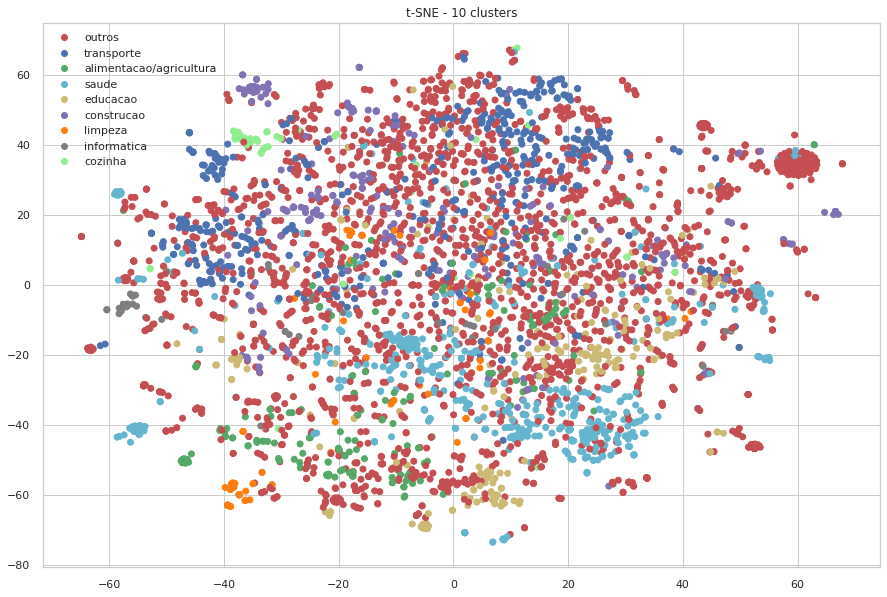

In [166]:
_, tsne_w2v_vectors, __, tsne_w2v_labels_ix = train_test_split(w2v_vectors, 
                                                            bids_with_items["SETOR"].index,
                                                            stratify=bids_with_items["SETOR"],
                                                            test_size=0.05,
                                                            random_state=42)

tsne_w2v_labels = bids_with_items["SETOR"][tsne_w2v_labels_ix].values

try:
    tsne = pickle.load(open('tsne_w2v.pickle', 'rb'))
except:
    tsne = TSNE(random_state=42).fit_transform(
        PCA(random_state=42, n_components=50).fit_transform(tsne_w2v_vectors))
    pickle.dump(tsne, open('tsne_w2v.pickle', 'wb'))

colours = ListedColormap(['r','b','g', 'c', 'k', 'y', 'm', 'tab:orange', 'tab:gray','lightgreen'])

_, legends_idx = np.unique(tsne_w2v_labels, return_index=True)
legend_labels = tsne_w2v_labels[np.sort(legends_idx)]
sectors_to_number = dict(zip(legend_labels, range(0, len(legend_labels))))


plt.figure(figsize=(15,10))
scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=[sectors_to_number[i] for i in tsne_w2v_labels], cmap=colours)



plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels.tolist(), loc='best')

plt.title('t-SNE - 10 clusters')

plt.show()


O gráfico acima apresenta alguns clusters bem definidos, como é o caso de algumas amostras das classes "limpeza", "cozinha", educacao e "construcao". "saude", "transporte" e "construcao", que são classes majoritárias depois de "outros", apresentam um certo agrupamento, mas ainda sim estão bem dispersa, assim como as amostras de "outros", espalhadas por todo o gráfico. 

Como há um grau muito grande de dispersão, um algoritmo como o KMeans, testado anteriormente, mesmo usando embedding, terá problemas em conseguir agrupar um dado assim com um grau de inércia baixo.

Um teste que pode ser feito é utilizar as classes já dadas acrescidas dos casos onde, para uma mesa descrição, a heurística determinou mais de uma classe, e utilizar um modelo multilabel para tentar encontrar 1 ou mais classes para cada amostra, tendo como base nossa rotulação.

Vamos testar esse método e ver se é possível obter um bom resultado:

## Usando classificação multilabel

Neste último passo do notebook, será realizado um teste utilizando uma rede neural para tentar classificar as amostras rotuladas manualmente. Uma rede neural é um modelo computacional criado que tenta simular o comportamento do cérebro humano utlizando centenas, milhares e às vezes milhões ou até bilhões de "mini" operadores matemáticos chamados de neurônios ou unidades. 

A rede neural é composta de camadas, cada uma com *n* neurônios. Cada neurônio de uma camada subsequente recebe de entrada a soma ponderada das saídas dos neurônios da camada anterior, ou seja, para cada saída de um neurônio da camada *c - 1*, é multiplicado por um valor (chamado de peso). Esses valores são somados e acrescentados de um outro valor, chamado de viés (*bias*, em inglês) e usados de entrada para um determinado neurônio da camada *c*. O aprendizado da rede tem o objetivo de descobrir os melhores valores para os pesos e os vieses a fim de suas saídas serem o mais próximo do dado usado de entrada o possível.

Neste caso específico, a saída será composta de 9 valores, um para cada setor que foi pré-determinado para as amostras. Isso é conhecido como classificação multilabel, ou seja, cada amostra pertence a um número *n* de classes. Dessa forma, o rótulo para cada amostra se trata de um vetor de 0's e 1's, indicando ausência e presença da classe *i* para aquela amostra.

Nesse contexto, para avaliar se os resultados preditos pela rede neural são bons, iremos usar 4 métricas (acurácia, precisão, recall e f1-score). Elas dependem do conceito de Verdadeiros/Falsos Positivos/Negativos. 

Verdadeiros positivos e negativos se referem a acertos. O primeiro se refere ao caso do modelo acertar a presença de uma classe no vetor de saída, ou seja, quando deveria ser "1" a saída para determinada classe e o modelo acertou; o segundo se refere ao caso oposto, quando a saída deve ser "0" e o modelo acerta.

Falsos positivos e negativos são erros. O primeiro diz respeito a quando o modelo prediz que uma amostra pertence a classe *i* e insere um valor "1" na posição *i* do vetor, mas na realidade aquele documento não é dessa classe; o segundo trata da situação contrária.

Sendo assim, nossa métricas são calculadas da seguinte maneira:

$$
\text{Acurácia} = \frac{TP + TN}{TP + TN + FP + FN} \\\
\text{Precisão} = \frac{TP}{TP + FP} \\\
\text{Recall} = \frac{TP}{TP + FN} \\\
\text{F1-Score} = \frac{2 \cdot \text{Precisão} \cdot \text{Recall}}{\text{Precisão} + \text{Recall}}
$$


Em relação ao resultado de cada uma, quanto mais prómixo de 1, melhor a perfomance do modelo.

Vamos ver os resultados na prática agora:

In [167]:
sectors_sets = [set(health), set(transportation), set(cleaning), set(education), set(construction),
                set(feeding_agriculture), set(kitchen), set(info_tech)]


classes = []
for doc in tokens_v3:
    classes_presence = []
    doc_vocab = set(doc)
    
    for sector_set in sectors_sets:
        if doc_vocab.intersection(sector_set):
            classes_presence.append(1)
        else:
            classes_presence.append(0)

    if 1 not in classes_presence:
        classes_presence.append(1)
    else:
        classes_presence.append(0)
    classes.append(classes_presence)
classes = np.array(classes)     

In [170]:
X_train, X_test, y_train, y_test = train_test_split(w2v_vectors, 
                                                    classes,
                                                    test_size=0.2,
                                                    random_state=42)

In [171]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(50, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(9,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [172]:
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_split=0.2)

Epoch 1/10
1649/1649 [==============================] - 7s 3ms/step - loss: 0.2449 - accuracy: 0.5778 - val_loss: 0.1418 - val_accuracy: 0.7234
Epoch 2/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.1233 - accuracy: 0.7727 - val_loss: 0.1129 - val_accuracy: 0.7854
Epoch 3/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.1110 - accuracy: 0.7881 - val_loss: 0.1027 - val_accuracy: 0.8118
Epoch 4/10
1649/1649 [==============================] - 6s 3ms/step - loss: 0.1031 - accuracy: 0.8023 - val_loss: 0.1036 - val_accuracy: 0.7963
Epoch 5/10
1649/1649 [==============================] - 5s 3ms/step - loss: 0.0974 - accuracy: 0.8104 - val_loss: 0.0959 - val_accuracy: 0.8241
Epoch 6/10
1649/1649 [==============================] - 6s 4ms/step - loss: 0.0942 - accuracy: 0.8170 - val_loss: 0.0976 - val_accuracy: 0.8014
Epoch 7/10
1649/1649 [==============================] - 6s 4ms/step - loss: 0.0904 - accuracy: 0.8192 - val_loss: 0.0911 - val_accuracy:

In [173]:
y_pred = model.predict(X_test)

In [174]:
norm_y_pred = []
for preds in y_pred:
    one_pred = []
    for pred in preds:
        if pred <= 0.5:
            one_pred.append(0)
        else:
            one_pred.append(1)
    norm_y_pred.append(one_pred)

In [175]:
classes_names = ["saude","transporte", "limpeza", "educacao", "construcao",
                "alimentacao/agricultura", "cozinha", "informatica", "outros"]

print(classification_report(y_test, norm_y_pred, target_names=classes_names))

                         precision    recall  f1-score   support

                  saude       0.96      0.86      0.90      2636
             transporte       0.94      0.77      0.85      2862
                limpeza       0.91      0.82      0.86       557
               educacao       0.91      0.80      0.85      2293
             construcao       0.86      0.65      0.74      1334
alimentacao/agricultura       0.94      0.86      0.90      1772
                cozinha       0.97      0.64      0.77       357
            informatica       0.88      0.72      0.79       295
                 outros       0.84      0.90      0.87      6677

              micro avg       0.89      0.83      0.86     18783
              macro avg       0.91      0.78      0.84     18783
           weighted avg       0.90      0.83      0.86     18783
            samples avg       0.85      0.84      0.84     18783



/home/joaorobson/Documentos/DSB/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [176]:
print("Acurácia:",accuracy_score(y_test, norm_y_pred))

Acurácia: 0.8085067653661793


Os resultados obtidos são muito bons! Uma acurácia de 80% quer dizer que de todas as 18.783 predições realizas, 80% delas acertaram na mosca as classes de cada amostra. Se formos avaliar erros para cada posição de cada conjunto de valores preditos, ou seja, quantos erros aconteceram em 9  * 18.783 (número de classes * amostras preditas), podemos usar outra métrica chamada Hamming Loss:

In [177]:
print("Hamming loss:", hamming_loss(y_test, norm_y_pred))

Hamming loss: 0.03434931806996609


Ela nos diz que de 169047 valores individuais preditos pelo modelo, menos de 5900 (5807) valores foram errados!

# Conclusão + Próximos passos

Após diversas análise, alguns pontos a se destacar são:
* É possível cruzar alguns dos dados e, combinado com algumas técnicas de ciência de dados, obter municípios que fogem do padrão de consumo para o seu porte ou para suas compras. Na análise feita nesse notebook, dois casos bem marcantes foram observardos: Viamão, em 2016, e Tapera, em 2019. Infelizmente, a investigação não pôde ir  mais a fundo, mas há uma diferença muito gritante entre os gastos nesses dois casos e o restante do dado;
* Infelizmente, o dado de licitações possui muitos valores de compras faltantes e isso impacta de certa forma a análise. Um próximo passo seria tentar gerar valores para esses registros utilizando as classes manualmente designadas + o modelo treinado acima;
* O teste com o texto das descrições pode avançar mais. Diversas abordagens não tratadas neste notebook podem ser testadas, o que inclui outros algoritmos de *embedding* (gloVe, doc2vec, etc.), modelos de classificação que não envolvam necessariamente redes neurais (XGBoost, RandomForest, SVM's, etc.), outros tipos de redes neurais (LSTM, CNN, etc.);
* O modelo acima pode ser usado para classificar amostras e novas análises exploratórias podem ser feitas, principalmente no dado predito erroneamente. Nessas amostras, a modelagem de tópicos pode ser aplicada novamente, checando os termos mais relevantes, atribuindo novamente classes, treinando o modelo, e assim por diante;
* Os gastos considerando as amostras preditas pelo modelo não foram avaliadas. É importante checar esse ponto também, porque uma fatia muito grande das compras foi alocada para outros.

Esses são alguns pontos interessante a serem considerados em análises futuras.

É importante lembrar que Ciência de Dados se trata de um processo que envolve muita experimentação. Infelizmente, não foi possível testar mais hipóteses e estratégias nesse notebook. Mas o resultado obtido já pode ser considerado bom.

Abaixo, algumas das referências mais importantes de bibliotecas usadas e para embasar as explicações técnicas:

# Referências

* [scikit-learn](https://scikit-learn.org/stable/index.html)
* [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/index.html)
* [Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](http://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
* [Latent Dirichlet Allocation (Part 1 of 2)](https://www.youtube.com/watch?v=T05t-SqKArY)
* [StatQuest: t-SNE, Clearly Explained](https://www.youtube.com/watch?v=NEaUSP4YerM)
* [The Illustrated Word2vec](https://jalammar.github.io/illustrated-word2vec/)